<a href="https://colab.research.google.com/github/yukinaga/object_detection/blob/main/section_2/01_faster_rcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### annotationデータ変換

In [1]:
import glob
import os
import json
import pandas as pd
import shutil
import json
import numpy as np
from tqdm import tqdm

In [4]:
# jsonファイルの読み込み
base_dir = 'datasets/COCOdata/COCOdata'
json_dicts = {}
data_kinds = ['train', 'test']
for data_kind in data_kinds:
    with open(f'{base_dir}/{data_kind}/labels_original.json', 'r') as f:
        json_dicts[data_kind] = json.load(f)

In [5]:
# imagesキー内の'id'と'file_name'と'width'と'height'を紐づけ
df_dict = {}
for data_kind, json_dict in json_dicts.items():
    images = json_dict['images']
    images_id = []
    for image in images:
        image_id = {}
        image_id['image_id'] = image['id']
        image_id['file_name'] = image['file_name']
        image_id['width'] = image['width']
        image_id['height'] = image['height']
        images_id.append(image_id)
    df_dict[data_kind] = pd.DataFrame(images_id)

In [8]:
# annotationsキー内の'id'と'bbox'と'category_id'を紐づけ
for data_kind,json_dict in json_dicts.items():
    annotations = json_dict['annotations']
    annotations_id = []
    for annotation in annotations:
        annotation_id = {}
        annotation_id['image_id'] = annotation['image_id']
        annotation_id['bbox'] = annotation['bbox']
        annotation_id['category_id'] = annotation['category_id']
        annotations_id.append(annotation_id)
    df_annotations_id = pd.DataFrame(annotations_id)
    df_dict[data_kind] = pd.merge(df_dict[data_kind], df_annotations_id, on='image_id')

In [10]:
# categoriesキー内の'id'と'name'を紐づけ
for data_kind,json_dict in json_dicts.items():
    categories = json_dict['categories']
    categories_id = []
    for category in categories:
        category_id = {}
        category_id['category_id'] = category['id']
        category_id['name'] = category['name']
        categories_id.append(category_id)
    df_categories_id = pd.DataFrame(categories_id)
    df_dict[data_kind] = pd.merge(df_dict[data_kind], df_categories_id, on='category_id')

In [12]:
# カテゴリ番号と名前を取り出したデータフレーム
df_unique_category = df_dict['test'][['category_id', 'name']].drop_duplicates()
df_unique_category = df_unique_category.sort_values('category_id')
df_unique_category = df_unique_category.reset_index(drop=True)
df_unique_category.index = np.arange(1, len(df_unique_category)+1)
df_unique_category

,category_id,name
1,1,person
2,3,car
3,10,traffic light
4,47,cup
5,62,chair


In [14]:
# もともとのカテゴリIDとラベルIDの変換
category_id2label_id = {}
for label_id, row in df_unique_category.iterrows():
    category_id2label_id[row['category_id']] = label_id
category_id2label_id[10]

3

In [16]:
# ラベルIDからNameを取得
label_id2name = {}
for label_id, row in df_label.iterrows():
    label_id2name[label_id] = row['name']
label_id2name[3]

'trafficlight'

In [17]:
columns = df_dict['test'].columns.tolist()

In [16]:
# train, valでデータフレームを分ける
# かなり時間かかるから注意！
train_txt = f'{base_dir}/train/train.txt'
val_txt = f'{base_dir}/train/val.txt'
with open(train_txt, 'r') as f:
    train_list = f.readlines()
    train_list = [train_name.split('/')[-1].replace('\n', '') for train_name in train_list]
with open(val_txt, 'r') as f:
    val_list = f.readlines()
    val_list = [val_name.split('/')[-1].replace('\n', '') for val_name in val_list]

df_train = pd.DataFrame(columns=columns)
for train_name in tqdm(train_list):
    _df = df_dict['train'][df_dict['train']['file_name'] == train_name]
    df_train = pd.concat([df_train, _df],ignore_index=True)
df_train

100%|████████████████████████████████████████████████████████████████████████████| 73559/73559 [30:42<00:00, 39.93it/s]


,image_id,file_name,width,height,bbox,category_id,name
0,28163,000000214306.jpg,640,424,"[81.04, 121.65, 23.72, 23.22]",47,cup
1,41476,000000314846.jpg,500,375,"[0.0, 1.6999999999999997, 353.74, 372.45]",1,person
2,41476,000000314846.jpg,500,375,"[158.13, 140.76, 182.87, 234.23999999999998]",1,person
3,32845,000000250165.jpg,640,426,"[224.71, 212.79, 142.11, 207.1]",62,chair
4,51501,000000389624.jpg,612,612,"[78.33, 321.25, 51.06, 90.19000000000001]",62,chair
...,...,...,...,...,...,...,...
362320,20191,000000152769.jpg,480,640,"[418.88, 113.91999999999999, 61.12, 197.29]",3,car
362321,20191,000000152769.jpg,480,640,"[35.96, 4.31, 372.49, 291.96]",1,person
362322,20191,000000152769.jpg,480,640,"[172.58, 310.21, 120.81, 99.24]",47,cup
362323,20191,000000152769.jpg,480,640,"[242.33999999999997, 283.81, 78.02, 77.29]",47,cup


In [17]:
len(df_train['image_id'].unique())

73559

In [18]:
len(train_list)

73559

In [21]:
df_val = pd.DataFrame(columns=columns)
for val_name in tqdm(val_list):
    _df = df_dict['train'][df_dict['train']['file_name'] == val_name]
    df_val = pd.concat([df_val, _df],ignore_index=True)
df_val

100%|██████████████████████████████████████████████████████████████████████████████| 3254/3254 [00:43<00:00, 74.10it/s]


,image_id,file_name,width,height,bbox,category_id,name
0,68183,000000516516.jpg,640,480,"[273.13, 0.0, 363.76, 369.65]",1,person
1,17402,000000131522.jpg,483,485,"[120.97999999999999, 7.63, 354.21, 468.65]",1,person
2,17402,000000131522.jpg,483,485,"[86.38, 65.26, 64.04, 71.16]",1,person
3,17402,000000131522.jpg,483,485,"[172.74, 23.74, 40.38, 63.86000000000001]",1,person
4,17402,000000131522.jpg,483,485,"[206.41, 23.08, 53.01, 57.45]",1,person
...,...,...,...,...,...,...,...
16027,27780,000000211281.jpg,427,640,"[227.93, 0.95, 95.63, 93.13]",1,person
16028,27780,000000211281.jpg,427,640,"[277.18, 0.81, 91.21, 99.51]",1,person
16029,27780,000000211281.jpg,427,640,"[369.02, 14.66, 57.00000000000001, 92.1]",1,person
16030,27780,000000211281.jpg,427,640,"[0.0, 0.0, 87.19, 83.57]",1,person


In [24]:
df_dict['train'] = df_train
df_dict['val'] = df_val

### カスタムデータセットを作成

In [18]:
import torch
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import draw_bounding_boxes
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [19]:
# カスタムデータセットに与えるデータを作成するクラス
class MSCOCODataset(torch.utils.data.Dataset):
    
    def __init__(self, df, image_dir, transform=None):
        super().__init__()
        self.image_ids = df['file_name'].unique()
        self.df = df
        self.image_dir = image_dir
        self.transform = transform
        
    def __getitem__(self, index):
        if self.transform is None:
            self.transform = transforms.Compose([
                transforms.ToTensor()
            ])

        # 入力画像の読み込み
        image_id = self.image_ids[index]
        image = Image.open(f'{self.image_dir}/{image_id}')
        image = self.transform(image)
        
        # アノテーションデータの読み込み
        df_unique_id = self.df[self.df['file_name'] == image_id]
        width = df_unique_id['width'].unique()[0]
        height = df_unique_id['height'].unique()[0]
        boxes_arr = np.array([boxes for boxes in df_unique_id['bbox'].values])
        boxes_arr[:, 0] = boxes_arr[:, 0]
        boxes_arr[:, 1] = boxes_arr[:, 1]
        boxes_arr[:, 2] = boxes_arr[:, 0] + boxes_arr[:, 2]
        boxes_arr[:, 3] = boxes_arr[:, 1] + boxes_arr[:, 3]
        boxes = torch.tensor(boxes_arr, dtype=torch.int64)
        for box in boxes:
            box[2] = box[2] + 1 if (box[2] - box[0]) == 0 else box[2]
            box[3] = box[3] + 1 if (box[3] - box[1]) == 0 else box[3]
        labels = [category_id2label_id[cat_id] for cat_id in df_unique_id['category_id'].values]
        labels = np.array(labels)
        labels = torch.tensor(labels, dtype=torch.int64)
        target = {}
        target['boxes'] = boxes
        target['labels']= labels
        
        return image, target
    
    def __len__(self):
        return self.image_ids.shape[0]

### データセットの読み込み

In [ ]:
dataset_train = MSCOCODataset(df_dict['train'], image_dir=f'{base_dir}/train/data')
dataset_val = MSCOCODataset(df_dict['val'], image_dir=f'{base_dir}/train/data')

In [20]:
dataset_test = MSCOCODataset(df_dict['test'], image_dir=f'{base_dir}/test/data')

### DataLoaderの設定

In [ ]:
data_loader_train =  DataLoader(dataset_train, batch_size=1, shuffle=True)
data_loader_val =  DataLoader(dataset_val, batch_size=1, shuffle=False)

In [21]:
data_loader_test =  DataLoader(dataset_test, batch_size=1, shuffle=False)

### ターゲットの表示

In [25]:
def show_boxes(image, boxes, names):
    drawn_boxes = draw_bounding_boxes(image, boxes, labels=names)

    plt.figure(figsize = (16,16))
    plt.imshow(np.transpose(drawn_boxes, (1, 2, 0)))  # チャンネルを一番後ろに
    plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  # ラベルとメモリを非表示に
    plt.show()

{'boxes': tensor([[[358, 218, 414, 320],
         [290, 217, 352, 316],
         [413, 223, 443, 304],
         [317, 219, 338, 230],
         [412, 219, 421, 231],
         [412, 157, 465, 295],
         [384, 172, 399, 207]]]), 'labels': tensor([[5, 5, 5, 5, 5, 1, 1]])}


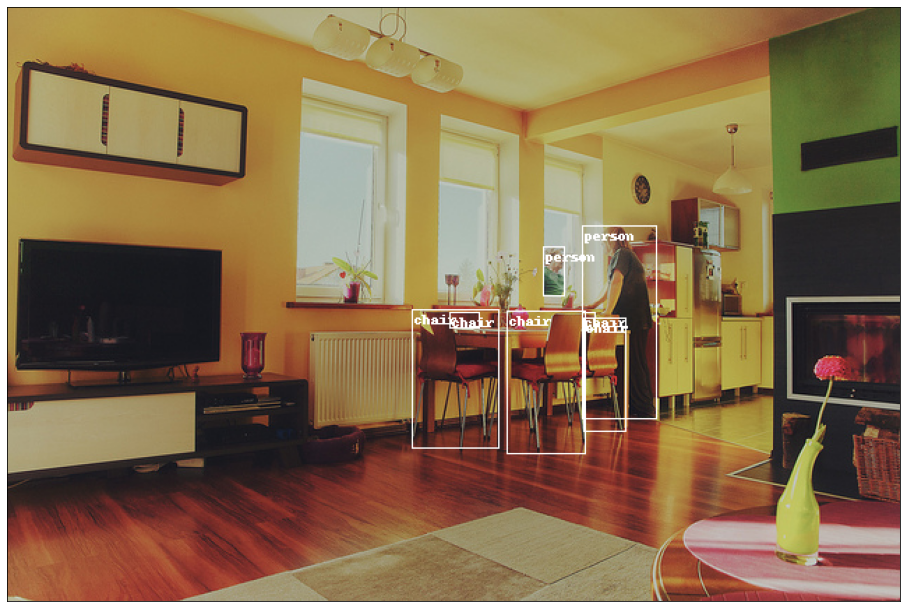

In [28]:
dataiter = iter(data_loader_test)  # イテレータ
image, target = dataiter.next()  # バッチを取り出す
print(target)

image = image[0]
image = (image*255).to(torch.uint8)  # draw_bounding_boxes関数の入力は0-255

boxes = target["boxes"][0]

labels = target["labels"][0]
names = [label_id2name[label.item()] for label in labels]

show_boxes(image, boxes, names)

### モデルの構築

In [87]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes=len(df_unique_category)+1  # 背景も含めて分類するため1を加える
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.cuda()  # GPU対応

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

### 学習

In [29]:
# モデルの保存場所の設定
data_path = 'save_model'
# ディレクトリを確認して作成
_dir_path = f'{data_path}'
if not os.path.exists(_dir_path):
    os.mkdir(_dir_path)
epoch_loss_path = f'{data_path}/losses_every_epoch.txt'
iter_loss_path = f'{data_path}/losses_every_iteration.txt'

In [ ]:
# 最適化アルゴリズム
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

epoch_loss_list = []
epoch_val_loss_list = []
iter_loss_list = []
val_loss_list = []
model.train()  # 訓練モード
epochs = 10
iteration = 0
for epoch in range(epochs):
    # train
    epoch_losses = []
    iter_losses = []
    for i, (image, target) in enumerate(data_loader_train):
        image = [img.cuda() for img in image]  # GPU対応

        boxes = target["boxes"][0].cuda()
        labels = target["labels"][0].cuda()
        target = [{"boxes":boxes, "labels":labels}]  # ターゲットは辞書を要素に持つリスト

        loss_dic = model(image, target)
        loss = sum(loss for loss in loss_dic.values())  # 誤差の合計を計算

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())
        iter_losses.append(loss.item())

        if (i+1)%100 == 0:  # 100回ごとに経過を表示
            print(f'Train epoch: {epoch+1} iteration: {i+1}, loss: {loss.item()}')
    
        # 1000iterationごとにmodelを保存
        if (i+1)%1000 == 0:
            model_path = f'{data_path}/save_model/model_iteration{i:06}.pth'
            torch.save(model.state_dict(), model_path)
            iter_loss_list.append(np.mean(iter_losses))
            iter_losses = [] 
            with open(iter_loss_path, 'w') as f:
                for i, loss in enumerate(iter_loss_list):
                    f.write(f'{(i+1)*1000} train_loss: {loss}\n')
            
    # 1epoch終わったらmodelを保存
    model_path = f'{data_path}/save_model/model_epoch{epoch:02}.pth'
    torch.save(model.state_dict(), model_path)
    epoch_loss_list.append(np.mean(epoch_losses))

    # validation
    val_losses =  []
    for i, (val_image, val_target) in enumerate(data_loader_val):
        val_image = [img.cuda() for img in val_image]  # GPU対応

        val_boxes = val_target["boxes"][0].cuda()
        val_labels = val_target["labels"][0].cuda()
        val_target = [{"boxes":val_boxes, "labels":val_labels}]  # ターゲットは辞書を要素に持つリスト

        val_loss_dic = model(val_image, val_target)
        val_loss = sum(val_loss for val_loss in val_loss_dic.values()) # 誤差の合計を計算

        val_losses.append(val_loss.item())

        if (i+1)%100 == 0:  # 100回ごとに経過を表示
            print("Val epoch:", epoch,  "iteration:", i,  "loss:", val_loss.item())
    
    val_loss_list.append(np.mean(val_losses))

    with open(epoch_loss_path, 'w') as f:
        for i, loss in enumerate(epoch_loss_list):
            f.write(f'{i+1} train_loss: {loss} val_loss: {val_loss_list[i]}\n')
   

### 検出

In [35]:
load_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes=len(df_unique_category)+1  # 背景も含めて分類するため1を加える
in_features = load_model.roi_heads.box_predictor.cls_score.in_features
load_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
load_model_pth = f'{data_path}/save_model03/model_epoch01.pth'
load_model.load_state_dict(torch.load(load_model_pth))
load_model.cuda()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [31]:
dataiter = iter(data_loader_test)  # イテレータ

C:\Users\tsubo\anaconda3\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


person 1 0.98 418.1 156.4 465.6 296.4
chair 5 0.94 289.5 217.2 356.2 319.3
chair 5 0.94 363.4 219.5 416.7 314.4
chair 5 0.80 403.2 219.3 441.4 307.2
person 1 0.77 11.2 337.4 310.8 421.6
person 1 0.75 384.7 171.2 400.4 206.3
person 1 0.59 45.8 212.2 61.4 240.3
cup 4 0.55 166.3 232.8 185.9 265.9


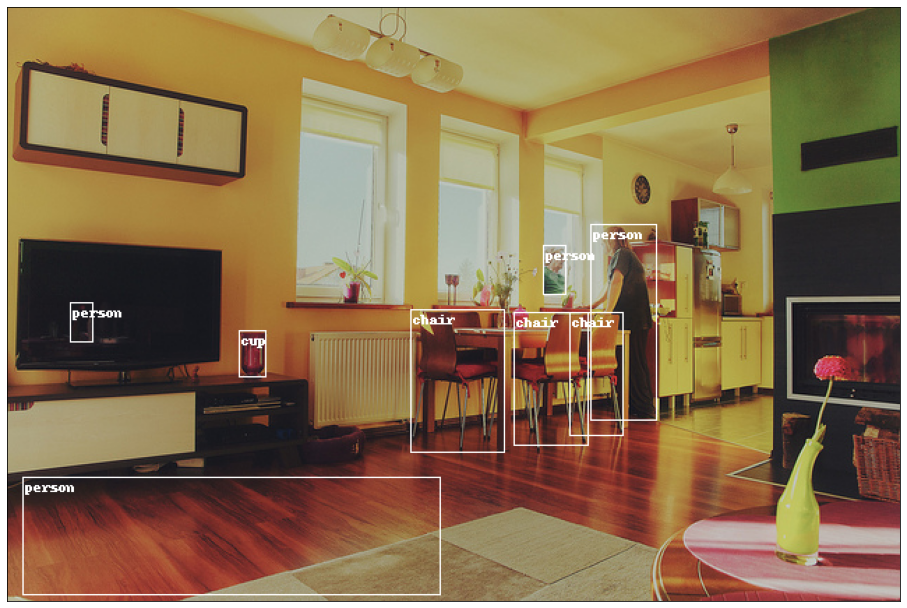

In [32]:
# 1枚ずつ検出テスト
image, target = dataiter.next()  # バッチを取り出す

image = [img.cuda() for img in image]  # GPU対応

load_model.eval()
predictions = load_model(image)
pred = predictions[0]

scores = pred['scores'].cpu().tolist()
boxes = pred['boxes'].cpu().tolist()
labels = pred['labels'].cpu().tolist()
names = [label_id2name[label] for label in labels]

iou50_scores = []
iou50_boxes = []
iou50_labels = []
iou50_names = []

for i, score in enumerate(scores):
    if score >= 0.5:
        iou50_scores.append(score)
        iou50_boxes.append(boxes[i])
        iou50_labels.append(labels[i])
        iou50_names.append(names[i])
        print(f'{names[i]} {labels[i]} {score:.02f} {boxes[i][0]:.01f} {boxes[i][1]:.01f} {boxes[i][2]:.01f} {boxes[i][3]:.01f}')
iou50_boxes = torch.tensor(iou50_boxes)

image = (image[0]*255).to(torch.uint8).cpu()
show_boxes(image, iou50_boxes, iou50_names)


In [36]:
# 検出結果の出力先設定
dets_dir_path = f'{data_path}/dets_result'
# ディレクトリを確認して作成
if not os.path.exists(dets_dir_path):
    os.mkdir(dets_dir_path)
img_names = df_dict['test']['file_name'].unique()

In [37]:
# 検出結果をファイルに出力
for i, (image, target) in enumerate(data_loader_test):

    image = [img.cuda() for img in image]  # GPU対応
    img_name = img_names[i]
    # うまく読めなかった画像(ImageID)をスキップ
    #if img_name == 'a8601676c86366e3':
    #    continue
    print(f'{i}: {img_name}')
    load_model.eval()
    predictions = load_model(image)
    pred = predictions[0]

    scores = pred['scores'].cpu().tolist()
    boxes = pred['boxes'].cpu().tolist()
    labels = pred['labels'].cpu().tolist()
    names = [label_id2name[label] for label in labels]

    iou50_scores = []
    iou50_boxes = []
    iou50_labels = []
    iou50_names = []

    img_name = img_name.split('.')[0]
    dets_file_path = f'{dets_dir_path}/{img_name}.txt'
    with open(dets_file_path, 'w') as f:
        for i, score in enumerate(scores):
            if score >= 0.5:
                iou50_scores.append(score)
                iou50_boxes.append(boxes[i])
                iou50_labels.append(labels[i])
                iou50_names.append(names[i])
                pred_data = f'{names[i]} {score:.03f} {int(boxes[i][0])} {int(boxes[i][1])} {int(boxes[i][2])} {int(boxes[i][3])}'
                f.write(f'{pred_data}\n')
                print(pred_data)

0: 000000000139.jpg
chair 0.977 291 215 355 320
chair 0.955 362 218 413 316
person 0.908 424 156 464 301
chair 0.882 376 217 434 314
chair 0.659 351 220 392 314
chair 0.589 402 217 442 316
chair 0.538 470 291 596 423
chair 0.538 325 216 371 310
cup 0.534 166 232 185 265
1: 000000000632.jpg
chair 0.898 251 227 342 319
chair 0.597 79 93 197 221
2: 000000001993.jpg
chair 0.992 109 244 220 408
3: 000000004134.jpg
person 0.996 243 40 591 425
person 0.992 36 44 299 425
person 0.988 10 108 73 261
person 0.983 297 125 336 275
person 0.973 576 109 639 328
person 0.973 238 127 274 207
person 0.938 349 137 381 193
person 0.934 467 109 523 178
person 0.918 516 139 536 181
cup 0.903 20 246 36 268
person 0.871 542 141 579 193
person 0.850 0 134 12 179
person 0.844 69 129 97 206
person 0.797 262 129 333 277
person 0.765 271 142 294 184
person 0.752 187 122 229 247
cup 0.745 221 247 239 271
person 0.696 1 118 77 375
person 0.695 71 130 97 171
person 0.637 9 130 31 222
person 0.607 593 176 638 424
pers

person 0.956 0 0 127 271
person 0.557 148 10 296 135
33: 000000027620.jpg
cup 0.887 150 289 238 436
chair 0.752 277 169 598 471
chair 0.677 413 159 618 446
chair 0.651 293 241 513 458
cup 0.626 176 110 213 174
chair 0.544 293 242 400 393
chair 0.529 0 381 47 479
34: 000000029596.jpg
chair 0.982 261 228 318 346
chair 0.856 12 262 238 427
chair 0.821 431 239 499 370
35: 000000029984.jpg
person 0.991 331 156 358 200
person 0.990 125 215 181 255
person 0.989 221 208 263 250
person 0.976 281 175 302 200
chair 0.866 263 295 410 444
chair 0.839 394 283 498 429
chair 0.801 339 288 464 440
chair 0.770 258 342 346 440
36: 000000030213.jpg
chair 0.970 309 333 547 448
chair 0.917 407 345 567 448
cup 0.767 186 341 248 408
cup 0.645 281 185 311 233
chair 0.606 590 320 639 448
37: 000000031248.jpg
chair 0.860 191 234 369 333
chair 0.678 6 277 103 332
38: 000000031296.jpg
person 0.996 28 108 87 254
person 0.992 371 50 405 133
chair 0.991 215 247 341 425
person 0.989 508 99 581 263
person 0.985 339 116

52: 000000041872.jpg
chair 0.983 316 254 425 367
chair 0.896 253 251 321 357
chair 0.717 3 178 105 275
chair 0.517 176 260 320 366
53: 000000042528.jpg
person 0.757 319 313 528 494
person 0.631 2 27 450 484
chair 0.599 23 151 305 484
person 0.569 5 42 135 479
54: 000000044068.jpg
chair 0.722 15 41 479 640
chair 0.625 374 380 479 553
55: 000000047112.jpg
chair 0.787 0 80 62 219
person 0.753 598 9 639 182
cup 0.707 296 11 384 198
chair 0.673 233 97 280 130
chair 0.564 56 113 321 216
56: 000000047769.jpg
chair 0.944 0 264 200 375
chair 0.938 310 270 393 374
chair 0.888 221 263 288 354
chair 0.779 213 191 290 352
57: 000000048396.jpg
person 0.995 404 48 595 388
person 0.995 124 0 350 420
cup 0.954 524 329 585 387
person 0.543 473 0 594 210
58: 000000050326.jpg
person 0.997 13 18 170 295
59: 000000050380.jpg
person 0.998 339 0 552 427
chair 0.968 0 243 117 427
person 0.949 214 30 337 370
chair 0.859 0 369 71 426
person 0.729 0 101 90 393
person 0.655 472 0 492 47
60: 000000050828.jpg
chair 

85: 000000074733.jpg
cup 0.974 399 327 534 560
cup 0.969 0 90 60 227
cup 0.969 281 407 437 609
cup 0.965 48 72 128 210
cup 0.961 180 41 246 154
cup 0.949 537 122 610 258
cup 0.949 121 54 189 178
cup 0.931 491 270 607 473
person 0.862 1 0 83 96
chair 0.861 350 68 469 143
person 0.775 4 0 215 95
person 0.737 0 1 79 208
person 0.737 0 215 345 612
cup 0.691 445 296 586 502
person 0.663 100 1 164 30
chair 0.587 406 3 508 109
cup 0.553 360 0 382 31
cup 0.504 133 42 233 166
86: 000000075612.jpg
person 0.998 299 170 382 462
person 0.998 380 189 438 422
person 0.995 421 195 462 391
person 0.987 99 175 250 480
person 0.983 254 173 310 419
person 0.979 84 221 130 322
person 0.965 214 209 304 417
person 0.957 183 173 225 251
chair 0.945 53 263 96 338
person 0.863 362 183 401 375
person 0.828 363 184 402 277
person 0.819 245 169 283 254
person 0.805 251 172 310 281
person 0.697 179 195 263 470
chair 0.665 0 261 60 335
person 0.620 2 245 67 330
person 0.581 214 206 258 258
chair 0.532 51 265 78 332


106: 000000091500.jpg
person 0.987 17 103 270 480
person 0.980 287 136 519 478
chair 0.957 445 277 543 480
chair 0.761 267 279 537 480
chair 0.711 527 381 638 480
chair 0.670 580 185 640 294
person 0.655 96 124 488 480
cup 0.543 340 77 360 123
107: 000000091779.jpg
cup 0.969 407 1 497 99
chair 0.801 78 1 302 91
chair 0.730 1 1 113 108
cup 0.690 570 8 637 84
cup 0.579 571 22 639 152
chair 0.537 26 0 217 100
108: 000000092091.jpg
person 0.989 254 157 431 480
chair 0.942 0 119 201 402
chair 0.813 6 129 144 311
chair 0.776 59 135 149 260
chair 0.754 2 135 95 380
chair 0.654 377 130 481 241
chair 0.623 88 224 256 377
chair 0.505 0 351 213 477
109: 000000092939.jpg
person 0.983 25 108 274 566
person 0.973 202 120 370 520
chair 0.937 0 303 43 406
cup 0.868 186 605 240 639
cup 0.843 405 486 423 561
110: 000000093353.jpg
person 0.961 0 100 330 478
person 0.744 126 44 471 480
chair 0.521 54 0 336 128
111: 000000093437.jpg
person 0.992 79 9 435 361
chair 0.976 427 169 488 276
chair 0.967 34 200 1

140: 000000132796.jpg
person 0.999 293 62 401 395
person 0.992 408 61 563 275
person 0.990 79 146 156 336
person 0.909 10 144 147 355
person 0.591 169 141 372 425
141: 000000133244.jpg
person 0.998 204 102 321 308
person 0.993 104 31 151 82
person 0.990 545 130 599 202
person 0.989 295 34 333 85
person 0.987 137 8 181 81
person 0.986 497 32 544 83
person 0.986 417 35 456 83
person 0.986 183 0 232 62
person 0.983 477 11 513 62
person 0.981 330 47 362 82
person 0.980 460 33 499 83
person 0.973 74 34 110 81
person 0.961 402 3 445 70
person 0.957 441 13 475 65
person 0.952 42 37 73 82
person 0.946 4 34 46 83
person 0.935 352 10 390 83
person 0.925 326 15 360 66
person 0.925 521 16 561 82
person 0.919 568 2 592 65
person 0.911 467 0 494 35
person 0.908 541 0 578 80
person 0.907 164 1 201 60
person 0.907 502 0 536 37
person 0.895 264 37 296 82
person 0.891 384 0 415 40
person 0.891 610 31 639 213
person 0.882 32 11 71 56
person 0.859 73 13 101 62
person 0.830 587 0 609 42
person 0.827 612 54

cup 0.970 316 167 399 278
cup 0.581 201 63 239 133
177: 000000167572.jpg
person 0.903 527 3 639 272
person 0.827 178 0 317 66
person 0.781 391 0 509 129
cup 0.696 273 391 356 424
person 0.690 462 0 635 373
person 0.615 70 0 536 112
person 0.565 55 0 576 421
person 0.539 364 0 606 424
178: 000000168593.jpg
chair 0.987 505 224 637 461
179: 000000170474.jpg
person 0.997 152 31 460 476
chair 0.849 488 406 601 475
180: 000000170670.jpg
cup 0.930 73 208 170 349
cup 0.917 464 77 525 203
cup 0.884 393 228 474 376
cup 0.838 291 64 339 143
cup 0.808 28 235 101 336
cup 0.805 233 108 302 182
cup 0.759 31 130 204 335
cup 0.731 38 116 203 210
chair 0.670 522 43 640 177
chair 0.633 46 0 221 106
cup 0.582 394 202 544 389
181: 000000171190.jpg
person 0.994 52 145 138 324
person 0.990 115 136 193 327
person 0.983 402 120 497 310
person 0.982 508 138 596 310
person 0.982 198 143 273 255
person 0.980 265 137 338 297
person 0.979 325 142 396 279
cup 0.940 340 270 393 371
person 0.908 507 152 630 386
person

206: 000000189775.jpg
person 0.998 157 107 289 348
person 0.998 81 88 129 256
person 0.984 21 56 76 165
person 0.978 440 106 488 174
person 0.977 482 114 532 174
person 0.975 0 75 25 273
person 0.966 0 73 27 170
person 0.963 358 122 390 172
person 0.958 163 75 212 157
person 0.951 125 85 170 156
person 0.945 474 60 513 131
person 0.945 376 0 415 87
person 0.943 398 112 434 173
person 0.940 314 134 354 171
person 0.936 415 87 452 145
person 0.925 197 19 236 68
person 0.923 603 0 639 49
person 0.915 233 0 264 62
person 0.914 615 132 639 228
person 0.885 494 39 529 98
person 0.881 300 0 333 65
person 0.879 558 114 625 221
person 0.852 277 21 310 82
person 0.821 462 40 491 90
person 0.820 209 46 259 135
person 0.809 266 58 300 115
person 0.790 250 37 286 102
person 0.790 346 5 386 103
person 0.785 381 111 403 163
person 0.772 193 5 213 48
person 0.772 266 0 299 40
person 0.767 586 20 625 93
person 0.726 566 83 604 141
person 0.723 501 0 530 54
person 0.713 339 121 363 169
person 0.712 531 

person 0.989 522 0 639 510
person 0.985 35 26 201 177
person 0.980 168 12 482 527
person 0.927 370 0 453 139
person 0.915 418 0 461 142
person 0.845 0 119 39 171
person 0.838 40 23 225 301
person 0.663 52 24 266 471
person 0.656 314 1 432 127
person 0.622 331 1 394 116
239: 000000224807.jpg
person 0.995 195 60 297 180
person 0.987 7 125 328 427
person 0.982 273 53 326 149
person 0.978 370 87 612 427
person 0.977 163 50 211 174
person 0.974 61 62 97 113
person 0.974 322 50 353 131
person 0.957 142 30 164 69
person 0.956 317 63 420 209
person 0.956 14 55 88 202
person 0.945 216 28 256 70
person 0.943 376 32 433 132
person 0.940 556 80 639 326
person 0.922 64 62 176 192
person 0.915 395 64 493 286
cup 0.897 242 167 264 186
person 0.887 169 33 185 51
person 0.873 0 56 34 208
person 0.862 0 208 65 412
person 0.845 0 56 36 108
person 0.825 64 39 82 61
person 0.822 553 30 625 115
person 0.821 514 66 579 139
person 0.804 319 69 439 315
cup 0.793 323 250 345 277
person 0.771 524 78 617 367
pers

259: 000000240023.jpg
person 0.993 200 143 397 640
person 0.953 268 0 354 49
person 0.877 156 0 233 49
chair 0.823 395 96 480 217
person 0.797 171 0 231 30
person 0.794 386 0 476 53
person 0.762 65 0 147 41
person 0.749 225 0 262 28
person 0.730 8 0 62 42
person 0.631 387 0 449 37
person 0.619 116 0 162 42
person 0.509 265 0 354 190
260: 000000240250.jpg
person 0.995 199 6 504 416
person 0.917 123 56 178 200
person 0.912 165 51 195 100
person 0.904 4 2 84 329
cup 0.899 559 305 612 447
chair 0.806 152 106 221 208
person 0.771 90 66 139 148
person 0.713 29 21 103 288
person 0.703 164 70 220 203
chair 0.670 497 130 612 370
person 0.615 93 65 150 219
chair 0.609 156 122 197 203
person 0.605 56 40 116 281
chair 0.544 19 92 169 325
person 0.527 122 51 171 141
chair 0.522 181 118 215 207
261: 000000241668.jpg
person 0.983 5 22 424 640
chair 0.727 306 492 423 640
262: 000000242934.jpg
chair 0.938 146 107 226 199
chair 0.660 52 98 131 211
chair 0.641 301 115 414 220
263: 000000242946.jpg
person

person 0.996 361 48 635 419
person 0.994 11 0 352 424
person 0.977 270 150 348 225
person 0.952 252 172 274 219
person 0.930 374 151 454 230
person 0.905 235 164 261 218
cup 0.877 424 200 447 233
person 0.849 252 173 273 197
cup 0.830 284 212 299 221
person 0.795 367 185 380 212
cup 0.764 337 229 364 250
chair 0.742 1 187 118 424
person 0.728 381 167 407 212
person 0.717 347 185 362 209
chair 0.628 0 188 238 424
person 0.612 393 152 442 214
person 0.551 274 155 346 344
person 0.510 274 166 309 222
cup 0.504 329 200 353 237
281: 000000273420.jpg
person 0.984 178 107 263 309
cup 0.829 174 286 191 310
chair 0.814 119 242 191 327
282: 000000273711.jpg
person 0.970 537 20 640 480
person 0.815 0 14 76 158
chair 0.729 446 57 547 201
person 0.689 550 2 636 136
cup 0.674 48 329 187 468
chair 0.577 55 37 106 129
chair 0.546 364 44 544 207
chair 0.531 346 38 463 202
chair 0.521 350 39 452 119
person 0.515 545 18 639 256
283: 000000274687.jpg
chair 0.667 9 103 263 473
chair 0.543 194 94 294 244
28

cup 0.947 351 54 597 403
person 0.909 68 0 273 67
person 0.751 66 0 183 60
person 0.581 159 0 270 59
chair 0.543 382 0 622 88
person 0.539 27 0 312 100
315: 000000313130.jpg
chair 0.966 52 124 130 274
chair 0.750 62 66 163 276
316: 000000313454.jpg
person 0.992 9 75 146 377
chair 0.594 382 302 539 386
317: 000000319369.jpg
person 0.996 290 212 340 367
person 0.996 476 201 544 328
person 0.996 331 212 381 371
car 0.982 575 194 609 215
person 0.982 203 277 251 356
car 0.982 601 193 638 219
person 0.966 256 262 296 356
car 0.914 218 170 280 190
car 0.822 553 191 578 210
car 0.568 546 197 556 208
person 0.561 402 291 415 334
car 0.536 555 198 576 209
trafficlight 0.514 489 117 506 142
318: 000000319935.jpg
chair 0.959 369 201 399 250
chair 0.937 104 223 258 380
chair 0.786 405 238 628 398
319: 000000321214.jpg
person 0.990 122 0 622 477
person 0.843 0 304 258 480
person 0.650 7 1 369 479
320: 000000322352.jpg
chair 0.981 146 181 247 358
chair 0.971 280 131 355 298
chair 0.841 51 64 130 216

352: 000000351810.jpg
person 0.969 10 91 108 263
chair 0.878 0 172 56 291
person 0.765 3 66 80 364
person 0.717 104 59 140 128
person 0.656 97 118 126 208
chair 0.591 3 170 83 339
person 0.577 1 55 56 259
person 0.536 99 141 297 369
chair 0.516 347 166 409 215
353: 000000353970.jpg
person 0.530 12 0 463 416
354: 000000356248.jpg
person 0.966 110 154 411 639
person 0.949 52 83 188 252
cup 0.942 74 238 109 278
chair 0.915 19 539 327 640
cup 0.914 114 247 145 288
cup 0.908 161 249 191 293
chair 0.768 0 420 125 640
chair 0.755 401 120 476 249
person 0.741 212 211 472 640
person 0.681 180 91 307 263
cup 0.663 89 242 144 288
person 0.621 171 79 335 411
chair 0.547 4 437 288 640
person 0.529 49 86 191 408
355: 000000356424.jpg
person 0.996 309 114 479 459
person 0.986 29 65 343 463
cup 0.977 132 461 238 640
car 0.954 325 193 382 236
person 0.917 265 164 311 268
person 0.865 263 167 327 371
cup 0.799 24 466 112 594
chair 0.592 329 309 475 456
356: 000000357978.jpg
person 0.999 239 121 329 372


395: 000000405970.jpg
chair 0.924 5 287 142 427
chair 0.716 580 323 638 426
chair 0.514 504 193 636 342
396: 000000407614.jpg
cup 0.793 133 285 184 356
397: 000000410496.jpg
person 0.997 46 85 242 626
person 0.983 236 116 313 225
person 0.979 304 180 372 236
person 0.978 127 0 200 86
person 0.975 238 0 297 86
person 0.969 253 52 317 162
person 0.964 310 4 381 98
person 0.962 363 70 422 213
person 0.960 75 0 137 87
person 0.952 301 125 367 217
person 0.945 186 0 241 87
person 0.945 79 41 137 172
person 0.942 249 191 301 236
person 0.922 116 122 169 174
person 0.914 303 48 351 128
person 0.905 0 125 51 225
person 0.857 0 196 40 241
person 0.838 58 117 114 212
person 0.823 331 99 367 161
person 0.816 136 54 185 139
person 0.759 220 71 257 157
person 0.740 358 75 393 153
person 0.554 238 0 306 159
person 0.528 305 9 372 175
person 0.523 186 1 251 157
person 0.509 382 193 411 229
398: 000000410650.jpg
person 0.996 170 147 259 387
person 0.981 599 0 620 44
person 0.978 593 83 627 121
person 

cup 0.856 5 1 76 99
cup 0.693 367 6 537 216
429: 000000435003.jpg
chair 0.808 249 302 540 425
chair 0.748 446 189 631 427
chair 0.574 1 177 179 423
chair 0.535 444 242 562 424
430: 000000435081.jpg
person 0.841 391 274 496 367
cup 0.687 360 376 448 478
person 0.616 7 241 107 395
431: 000000435208.jpg
person 0.955 10 308 185 596
chair 0.916 141 312 254 422
chair 0.652 266 394 475 640
person 0.573 130 204 170 243
chair 0.539 1 573 156 639
432: 000000436617.jpg
person 0.989 58 179 243 425
person 0.986 402 139 556 362
person 0.981 30 128 99 259
person 0.968 186 123 289 315
person 0.963 304 117 364 192
person 0.947 369 132 426 254
person 0.939 247 125 328 260
person 0.915 415 142 451 241
person 0.900 0 144 42 198
person 0.889 248 124 295 214
chair 0.882 0 203 42 309
person 0.874 102 135 133 187
person 0.806 126 140 186 188
person 0.772 0 144 46 261
person 0.760 290 117 362 258
chair 0.690 43 188 117 279
person 0.664 127 136 151 181
person 0.663 3 132 75 249
cup 0.584 307 269 338 309
person 

chair 0.893 3 341 176 457
cup 0.833 1 2 87 127
cup 0.761 396 319 433 384
chair 0.709 382 347 626 456
461: 000000464358.jpg
chair 0.925 280 168 381 282
462: 000000465822.jpg
person 0.985 324 162 448 344
person 0.966 435 169 499 264
person 0.963 281 172 337 285
person 0.939 0 176 52 277
person 0.939 58 106 200 276
person 0.929 24 104 269 368
person 0.923 403 171 451 262
person 0.862 427 169 497 335
person 0.837 323 160 410 287
person 0.820 216 152 310 317
person 0.750 480 180 499 235
person 0.743 55 44 142 227
person 0.731 254 161 328 306
chair 0.699 1 261 240 374
person 0.685 435 148 480 199
person 0.642 19 168 67 272
chair 0.641 422 231 491 345
person 0.599 284 173 325 243
person 0.534 442 172 490 225
person 0.533 157 123 429 317
463: 000000466125.jpg
person 0.990 3 208 246 640
person 0.750 319 208 426 640
person 0.655 224 0 416 215
person 0.510 228 2 412 107
person 0.508 294 41 427 562
person 0.504 0 353 44 584
464: 000000467176.jpg
person 0.993 267 215 404 427
person 0.993 7 164 182 

person 0.991 264 0 582 427
person 0.990 54 102 120 228
cup 0.932 158 367 263 425
person 0.792 46 118 71 161
person 0.649 45 116 76 224
cup 0.623 1 207 46 305
cup 0.594 76 211 242 344
498: 000000492758.jpg
chair 0.962 6 244 141 427
chair 0.958 326 203 407 306
chair 0.929 44 193 187 319
chair 0.926 546 202 628 331
chair 0.875 434 218 511 306
person 0.871 446 189 517 295
chair 0.778 254 200 337 301
chair 0.536 435 236 477 304
chair 0.536 403 336 617 426
499: 000000493905.jpg
person 0.994 244 114 382 488
person 0.987 400 119 458 177
person 0.986 501 0 557 91
person 0.984 120 71 172 171
person 0.973 446 0 501 93
person 0.972 459 128 513 179
person 0.972 169 65 229 162
person 0.963 0 72 53 158
person 0.959 461 62 523 172
person 0.958 288 76 340 166
person 0.956 392 1 445 113
person 0.951 56 0 111 88
person 0.949 336 0 391 82
person 0.925 279 0 335 72
person 0.914 337 90 399 176
person 0.889 401 70 472 165
person 0.888 1 0 34 43
person 0.881 220 0 288 105
person 0.864 233 68 299 178
person 0.

person 0.521 27 350 199 452
543: 000000540962.jpg
person 0.601 4 142 216 294
cup 0.558 281 194 297 221
544: 000000541123.jpg
person 0.999 300 267 364 354
person 0.999 381 156 412 229
person 0.998 530 176 569 241
person 0.997 107 253 164 338
person 0.992 352 134 370 189
person 0.985 78 165 97 204
person 0.956 576 73 594 96
person 0.933 529 74 546 94
person 0.919 312 69 330 90
person 0.912 591 75 605 97
person 0.887 157 4 174 44
person 0.850 598 56 613 81
person 0.839 37 171 52 187
person 0.812 79 61 92 85
person 0.808 322 16 335 40
person 0.807 438 8 453 26
person 0.804 139 45 151 64
person 0.794 421 71 432 92
person 0.791 448 51 465 73
person 0.760 609 27 623 51
person 0.757 244 73 255 90
person 0.755 447 75 458 92
person 0.751 260 36 270 57
person 0.731 55 47 73 83
person 0.728 550 44 564 72
person 0.725 429 47 441 71
person 0.722 166 64 179 90
person 0.722 117 51 129 74
person 0.717 106 33 117 54
person 0.717 236 38 253 83
person 0.715 329 1 341 21
person 0.714 28 170 38 189
person 0

person 0.579 55 181 99 323
person 0.572 0 197 41 312
person 0.527 236 202 248 216
558: 000000563470.jpg
person 0.974 89 87 211 328
chair 0.957 0 6 55 105
559: 000000563882.jpg
person 0.924 0 0 391 421
person 0.901 0 0 184 363
person 0.899 287 0 634 425
person 0.796 258 106 377 253
person 0.786 221 107 429 424
person 0.675 124 45 525 425
person 0.670 515 0 639 425
person 0.652 132 33 257 249
person 0.526 111 63 409 328
560: 000000564336.jpg
person 0.951 109 101 191 280
chair 0.809 193 181 241 238
chair 0.779 243 174 330 234
chair 0.753 4 166 92 351
chair 0.732 0 170 36 289
chair 0.672 243 168 338 358
car 0.665 438 171 487 204
chair 0.628 44 152 236 358
chair 0.620 179 173 246 354
chair 0.598 185 150 237 202
561: 000000568584.jpg
chair 0.754 16 219 280 417
chair 0.671 374 149 546 391
chair 0.602 146 173 282 421
chair 0.559 16 49 326 420
person 0.530 378 44 545 396
562: 000000568710.jpg
chair 0.706 419 182 631 415
chair 0.590 406 158 433 211
chair 0.561 452 166 477 192
chair 0.558 198 187

601: 000000003934.jpg
person 0.992 195 106 236 227
person 0.985 157 83 203 227
person 0.942 94 145 226 308
person 0.931 93 90 156 187
person 0.906 297 131 324 179
person 0.896 89 118 221 442
person 0.853 45 81 112 368
person 0.755 295 135 325 218
person 0.688 47 89 144 479
person 0.632 142 86 214 276
602: 000000004395.jpg
person 0.976 0 0 425 639
person 0.748 327 388 424 639
person 0.607 0 372 180 620
person 0.589 15 0 363 348
person 0.521 139 253 422 610
603: 000000004765.jpg
person 0.997 221 121 399 395
604: 000000005001.jpg
person 0.994 77 222 189 480
person 0.979 234 257 346 480
person 0.978 338 51 405 155
person 0.972 340 90 519 480
person 0.966 433 35 504 164
person 0.965 167 31 257 378
person 0.961 36 82 202 357
person 0.953 294 52 353 141
person 0.914 530 62 616 312
person 0.903 537 75 638 446
person 0.902 7 33 87 184
person 0.895 331 51 360 102
person 0.839 525 52 568 281
person 0.836 218 73 336 356
person 0.811 111 84 199 340
person 0.707 231 61 281 306
person 0.704 410 70 52

647: 000000013201.jpg
person 0.985 97 172 294 530
648: 000000013291.jpg
person 0.998 41 63 174 301
person 0.995 162 134 245 267
person 0.992 241 134 310 285
person 0.986 297 140 489 302
person 0.764 23 165 30 180
person 0.748 53 159 60 178
person 0.634 210 141 248 264
649: 000000013348.jpg
person 0.990 348 270 355 290
person 0.928 15 279 26 292
person 0.874 38 263 45 276
person 0.805 122 271 129 288
person 0.745 6 0 231 153
car 0.729 586 267 598 274
person 0.659 5 286 15 306
person 0.635 6 286 14 295
car 0.617 16 289 39 308
car 0.603 53 270 68 282
650: 000000013546.jpg
person 0.995 480 38 570 254
person 0.995 455 44 473 101
651: 000000013729.jpg
person 0.997 366 46 477 428
person 0.996 255 63 333 371
person 0.995 81 84 227 456
person 0.984 147 78 245 337
person 0.830 149 73 218 224
652: 000000013774.jpg
person 0.998 268 279 302 367
653: 000000014473.jpg
person 0.966 279 268 296 307
person 0.954 320 269 336 312
person 0.943 200 258 218 293
person 0.912 76 244 94 272
person 0.888 25 224 

695: 000000025057.jpg
person 0.996 96 243 143 327
person 0.992 126 4 373 427
696: 000000025181.jpg
person 0.983 50 221 65 255
person 0.953 98 229 113 248
person 0.578 97 229 106 248
697: 000000025228.jpg
person 0.992 230 151 453 408
698: 000000025393.jpg
person 0.999 152 70 284 475
person 0.999 371 130 496 479
car 0.888 2 193 69 238
person 0.802 93 192 115 243
699: 000000025394.jpg
person 0.991 37 137 283 553
cup 0.967 243 440 366 640
person 0.926 434 260 479 425
person 0.831 360 419 477 556
700: 000000025424.jpg
person 0.977 127 294 276 640
701: 000000025560.jpg
cup 0.906 1 422 72 480
person 0.872 204 34 348 203
person 0.821 125 25 517 359
person 0.733 158 30 354 311
chair 0.542 112 109 575 460
702: 000000026204.jpg
person 0.987 14 226 36 281
person 0.986 32 235 55 289
car 0.972 166 246 286 331
car 0.972 377 256 505 329
car 0.969 582 250 638 318
car 0.965 524 259 604 308
car 0.947 137 231 201 295
car 0.929 394 245 430 263
car 0.923 432 245 478 264
car 0.920 468 256 524 300
trafficligh

749: 000000038210.jpg
person 0.999 69 265 208 554
person 0.995 25 330 42 374
750: 000000038678.jpg
person 0.987 13 93 399 611
person 0.971 67 79 166 320
person 0.722 52 185 76 283
person 0.673 54 186 69 224
person 0.672 21 11 280 368
cup 0.565 150 550 260 639
751: 000000038829.jpg
person 0.998 579 136 639 252
person 0.995 221 87 340 396
person 0.994 446 127 535 319
person 0.994 314 92 408 373
person 0.984 410 129 454 264
752: 000000039480.jpg
person 0.999 246 164 340 426
person 0.821 159 0 183 22
person 0.799 122 0 147 18
person 0.589 160 0 201 25
person 0.557 584 0 606 21
person 0.500 157 0 228 36
753: 000000039551.jpg
person 0.996 113 51 316 347
754: 000000039785.jpg
person 0.998 201 173 269 258
person 0.607 410 139 416 152
person 0.603 406 118 426 152
755: 000000039914.jpg
person 0.998 52 198 320 571
person 0.941 384 222 392 238
person 0.940 405 223 413 237
person 0.937 121 214 128 234
person 0.904 106 218 112 233
person 0.875 255 302 308 526
person 0.832 440 219 452 232
person 0.76

person 0.911 0 107 480 640
person 0.638 1 286 330 640
812: 000000054164.jpg
person 0.998 185 99 325 347
813: 000000054592.jpg
person 0.964 301 34 535 418
person 0.719 94 148 198 324
814: 000000054654.jpg
person 0.991 108 49 373 640
cup 0.664 52 330 167 454
cup 0.642 0 351 42 463
815: 000000054931.jpg
person 0.996 205 144 383 637
person 0.724 242 154 381 455
816: 000000054967.jpg
car 0.967 211 431 268 475
car 0.961 149 419 179 439
car 0.960 107 422 150 461
car 0.958 254 431 278 465
trafficlight 0.950 161 357 171 373
car 0.936 53 422 93 459
car 0.928 1 432 34 469
car 0.918 24 431 56 465
car 0.883 181 419 197 435
car 0.866 228 413 240 424
car 0.851 196 417 211 430
car 0.771 177 421 190 436
person 0.762 376 418 423 639
car 0.738 171 421 180 437
car 0.714 213 414 224 428
car 0.703 14 432 46 467
car 0.696 208 415 215 428
trafficlight 0.628 98 401 104 409
car 0.580 172 421 186 436
trafficlight 0.556 103 384 111 396
person 0.514 0 433 13 472
817: 000000055002.jpg
cup 0.829 158 206 317 363
cup 

840: 000000060932.jpg
person 0.994 51 170 113 373
person 0.993 377 68 636 427
person 0.990 135 152 192 360
person 0.986 192 172 307 378
person 0.976 99 178 176 369
person 0.926 300 185 334 336
person 0.831 195 167 241 304
person 0.787 384 177 414 244
person 0.715 323 136 424 413
person 0.709 188 180 203 207
person 0.682 273 180 312 352
person 0.676 251 181 273 224
person 0.564 234 170 268 229
person 0.519 275 184 303 247
841: 000000061268.jpg
person 0.993 54 274 79 334
trafficlight 0.737 546 198 564 235
trafficlight 0.622 549 220 563 234
trafficlight 0.585 550 114 586 159
trafficlight 0.547 545 199 563 216
842: 000000061747.jpg
person 0.998 219 19 434 527
person 0.507 112 218 130 266
843: 000000061960.jpg
person 0.902 197 6 634 371
person 0.892 12 43 487 371
person 0.869 366 5 632 192
person 0.597 511 6 632 153
chair 0.581 5 207 121 371
844: 000000062353.jpg
person 0.975 81 218 111 270
person 0.960 14 227 56 308
person 0.922 138 238 161 264
person 0.864 54 233 86 267
chair 0.864 306 28

person 0.983 111 29 354 512
person 0.949 151 49 304 296
person 0.538 125 244 345 523
882: 000000072795.jpg
person 0.997 448 236 481 337
person 0.996 310 250 361 336
person 0.994 403 273 442 335
person 0.993 56 194 74 243
person 0.974 94 426 184 479
person 0.972 341 367 427 480
person 0.960 497 240 638 477
person 0.958 0 392 96 479
person 0.941 416 369 513 480
person 0.929 282 414 336 479
person 0.896 333 366 383 478
person 0.895 191 371 232 426
person 0.891 287 373 344 467
person 0.847 183 413 252 479
person 0.786 245 378 291 408
person 0.769 48 192 57 211
person 0.767 360 178 377 204
person 0.763 520 0 529 17
person 0.691 503 0 512 19
person 0.689 453 192 464 208
person 0.665 84 98 98 112
person 0.627 330 184 339 200
person 0.626 352 175 363 201
person 0.619 47 22 58 38
person 0.607 466 4 477 22
person 0.601 244 379 294 437
person 0.598 513 2 521 18
person 0.587 447 170 456 190
person 0.584 409 195 420 205
person 0.583 430 170 444 195
person 0.576 189 417 306 480
person 0.573 180 376 

person 0.793 14 0 134 122
cup 0.739 217 66 259 127
person 0.724 10 0 216 219
cup 0.660 432 4 497 66
person 0.590 437 134 498 275
921: 000000083540.jpg
person 0.992 332 247 376 414
person 0.752 96 16 246 389
922: 000000084031.jpg
person 0.998 99 216 164 358
person 0.998 281 186 374 334
person 0.997 183 254 288 351
person 0.989 27 211 48 272
person 0.979 9 216 31 274
person 0.967 101 215 118 264
person 0.965 212 199 224 254
person 0.963 45 212 66 271
person 0.954 86 212 103 266
person 0.947 0 220 17 274
person 0.934 269 202 285 250
person 0.926 371 185 380 209
person 0.916 334 192 373 262
person 0.904 15 27 27 54
person 0.878 254 185 264 211
person 0.871 518 200 528 229
person 0.866 104 41 115 66
person 0.865 546 199 554 225
person 0.852 60 30 86 61
person 0.846 63 210 79 269
person 0.845 487 199 498 231
person 0.842 397 187 407 209
person 0.840 111 41 123 67
person 0.838 283 202 302 249
person 0.832 447 199 457 234
person 0.828 480 198 496 231
person 0.823 221 201 240 255
person 0.812 6

person 0.998 296 70 429 360
963: 000000094751.jpg
trafficlight 0.944 111 76 157 173
car 0.935 313 274 372 305
trafficlight 0.902 2 223 11 245
person 0.849 74 251 80 267
person 0.817 199 253 207 271
person 0.815 265 254 280 287
person 0.808 95 252 103 276
person 0.794 56 253 63 270
person 0.787 98 252 106 276
person 0.760 66 252 74 273
person 0.701 107 253 114 273
person 0.637 237 250 245 259
person 0.552 247 252 253 259
trafficlight 0.542 219 230 226 249
person 0.539 207 253 217 275
car 0.534 317 274 371 289
964: 000000094871.jpg
person 0.998 124 0 284 392
person 0.994 278 0 374 214
person 0.991 0 0 47 166
person 0.939 370 69 478 478
965: 000000094944.jpg
person 0.996 175 189 202 266
person 0.994 355 217 465 416
person 0.969 563 227 623 294
person 0.655 557 229 577 274
966: 000000095155.jpg
person 0.999 442 42 522 149
person 0.999 437 208 574 387
person 0.998 128 58 194 142
person 0.997 109 249 225 378
967: 000000095862.jpg
person 0.997 408 108 429 161
person 0.996 74 140 112 224
perso

1002: 000000106912.jpg
person 0.995 235 229 283 398
1003: 000000107094.jpg
person 0.998 476 73 608 419
1004: 000000107226.jpg
person 0.991 345 68 478 424
person 0.967 139 126 302 366
person 0.946 283 140 327 216
person 0.904 1 112 152 567
person 0.900 62 113 120 219
person 0.896 323 137 356 213
person 0.895 110 123 157 205
person 0.828 343 141 387 266
person 0.669 6 130 143 372
person 0.655 0 126 23 227
person 0.636 347 140 369 165
person 0.597 0 104 29 378
person 0.554 134 129 243 306
person 0.538 211 129 308 237
person 0.534 108 126 161 278
person 0.522 88 126 120 215
person 0.510 6 152 80 341
1005: 000000107339.jpg
person 0.997 129 16 181 120
person 0.989 47 81 81 136
chair 0.638 5 86 54 139
1006: 000000107851.jpg
person 0.946 418 253 441 306
person 0.808 35 226 59 271
person 0.799 320 242 358 317
person 0.740 15 227 31 263
person 0.726 354 240 402 316
person 0.711 390 239 404 265
person 0.581 361 239 397 286
person 0.575 343 244 357 274
person 0.535 394 252 433 382
person 0.525 0 7

person 0.955 554 98 639 419
person 0.919 8 2 255 424
person 0.881 300 38 485 439
person 0.847 4 120 162 477
cup 0.783 476 302 565 438
person 0.740 31 115 309 374
person 0.717 39 146 177 358
person 0.608 319 47 473 288
person 0.603 0 232 80 480
person 0.569 46 284 67 341
1054: 000000121591.jpg
1055: 000000121673.jpg
person 0.998 145 77 287 246
1056: 000000121744.jpg
person 0.993 491 0 638 426
person 0.990 169 71 357 426
person 0.977 143 2 215 129
person 0.977 186 0 238 85
person 0.972 446 1 518 98
person 0.960 343 1 435 100
person 0.948 228 1 310 101
person 0.931 281 0 348 93
person 0.920 78 18 129 125
person 0.855 2 17 109 129
person 0.751 601 0 639 70
person 0.750 173 1 232 126
person 0.745 489 0 532 62
person 0.729 560 2 626 120
person 0.715 535 5 628 193
person 0.682 0 2 58 120
person 0.647 523 1 561 85
person 0.641 394 2 454 77
cup 0.568 4 104 66 302
person 0.537 110 11 165 126
cup 0.536 21 43 34 61
person 0.518 423 2 460 97
1057: 000000122166.jpg
person 0.997 69 227 148 459
person

person 0.994 45 0 480 640
1095: 000000131556.jpg
person 0.998 229 80 370 303
person 0.953 217 220 245 286
person 0.880 521 189 531 205
person 0.821 589 172 597 193
person 0.760 598 165 610 191
person 0.724 567 185 572 198
person 0.516 579 181 586 195
1096: 000000132375.jpg
person 0.971 584 42 597 68
cup 0.935 119 159 266 386
person 0.892 263 21 567 381
person 0.886 556 45 584 70
person 0.798 6 181 346 479
cup 0.717 328 203 469 476
person 0.690 569 46 583 69
cup 0.657 120 5 256 195
person 0.604 416 139 635 325
person 0.555 2 283 199 480
cup 0.531 588 108 609 145
1097: 000000132408.jpg
person 0.998 30 292 102 449
person 0.936 393 304 417 376
1098: 000000132544.jpg
person 0.998 10 12 187 410
person 0.992 431 72 626 366
person 0.974 360 146 453 341
person 0.929 307 145 381 258
person 0.884 258 0 334 189
person 0.737 370 147 439 274
person 0.729 573 1 637 103
person 0.629 572 0 636 243
person 0.505 519 20 632 344
1099: 000000132587.jpg
person 0.991 122 9 317 375
person 0.990 502 0 545 69
pe

1127: 000000139872.jpg
person 0.928 0 145 95 480
person 0.562 92 58 481 456
1128: 000000140203.jpg
person 0.997 486 13 582 248
person 0.965 1 19 31 123
person 0.804 16 20 35 83
person 0.766 0 73 39 407
person 0.528 24 27 37 66
1129: 000000140270.jpg
person 0.997 293 58 360 227
1130: 000000140286.jpg
person 0.984 448 224 515 296
chair 0.676 332 275 433 441
person 0.629 256 266 280 333
person 0.629 452 224 511 375
chair 0.596 423 285 630 455
1131: 000000140556.jpg
person 0.999 470 11 620 457
person 0.999 56 67 175 457
person 0.995 132 7 363 455
car 0.776 5 258 45 273
person 0.555 309 136 369 337
car 0.550 22 260 45 272
1132: 000000140583.jpg
person 0.957 318 255 338 293
person 0.925 287 263 303 292
person 0.518 317 254 357 294
1133: 000000140640.jpg
person 0.993 111 61 303 426
person 0.991 272 49 477 419
person 0.989 433 90 600 394
1134: 000000140840.jpg
person 0.989 203 96 221 151
person 0.955 69 114 77 136
person 0.834 45 122 50 136
person 0.819 0 109 10 123
person 0.791 30 124 35 137


1150: 000000144333.jpg
person 0.983 107 126 332 492
car 0.922 3 141 143 269
car 0.715 124 131 276 219
car 0.700 249 123 394 238
car 0.673 0 133 315 279
car 0.572 69 146 145 267
car 0.559 189 139 271 213
1151: 000000144784.jpg
cup 0.838 24 5 167 260
person 0.824 251 305 370 500
cup 0.817 136 21 340 284
cup 0.728 161 136 308 308
person 0.624 0 218 367 496
person 0.512 6 34 244 499
1152: 000000144932.jpg
1153: 000000144984.jpg
person 0.990 73 166 399 640
cup 0.798 3 3 181 338
cup 0.527 185 0 416 237
1154: 000000145020.jpg
person 0.984 0 194 32 288
person 0.976 45 239 85 298
person 0.972 201 197 231 271
person 0.970 167 212 183 276
person 0.964 411 130 438 202
person 0.963 256 183 281 276
person 0.961 87 216 101 274
person 0.939 218 202 237 269
person 0.899 137 192 157 226
person 0.790 125 196 144 227
person 0.772 7 237 44 300
person 0.767 278 107 422 309
person 0.743 183 219 201 239
person 0.734 167 212 182 243
person 0.732 450 0 474 43
person 0.698 429 1 463 68
person 0.592 202 190 221 2

person 0.965 268 166 347 304
cup 0.958 220 439 267 526
person 0.914 0 0 309 640
person 0.787 327 0 470 640
person 0.692 258 155 300 236
person 0.634 3 27 182 410
1183: 000000151962.jpg
1184: 000000152120.jpg
person 0.993 249 22 470 337
1185: 000000152214.jpg
person 0.995 38 0 473 640
1186: 000000152686.jpg
person 0.998 229 17 403 387
person 0.997 0 98 32 388
1187: 000000153229.jpg
person 0.997 521 211 637 457
person 0.997 338 144 491 446
person 0.996 117 217 194 392
person 0.986 162 102 280 401
person 0.985 180 19 339 405
person 0.980 516 172 580 397
person 0.716 146 206 193 340
1188: 000000153529.jpg
person 0.999 190 93 241 255
person 0.998 121 83 192 282
person 0.994 284 40 429 591
person 0.992 0 95 57 413
person 0.859 0 98 33 254
car 0.630 75 254 128 293
person 0.581 96 136 103 147
1189: 000000153669.jpg
person 0.998 108 127 180 303
person 0.993 53 119 117 300
person 0.990 445 195 504 305
person 0.990 517 0 589 86
person 0.989 282 96 363 307
person 0.987 344 52 540 407
person 0.987 

1216: 000000161397.jpg
person 0.813 79 0 610 474
person 0.810 93 0 342 442
1217: 000000161609.jpg
person 0.993 107 189 168 338
person 0.984 154 213 205 346
person 0.918 61 274 414 480
person 0.785 160 49 636 480
person 0.554 126 195 189 341
1218: 000000161781.jpg
person 0.994 264 13 464 363
1219: 000000161799.jpg
person 0.998 192 69 308 240
person 0.996 585 219 609 288
person 0.975 49 224 69 269
person 0.635 286 256 294 277
1220: 000000161861.jpg
person 0.998 175 72 275 321
1221: 000000161875.jpg
person 0.998 172 67 275 392
person 0.682 183 214 264 392
1222: 000000161879.jpg
person 0.998 56 0 224 348
1223: 000000161925.jpg
person 0.996 234 93 430 640
person 0.986 6 92 213 637
person 0.695 240 95 400 425
person 0.612 0 96 198 386
1224: 000000161978.jpg
person 0.990 399 7 448 55
person 0.990 371 9 390 49
person 0.989 530 5 627 129
person 0.989 190 5 234 87
person 0.977 261 160 307 256
person 0.953 250 6 285 85
person 0.946 306 3 374 100
person 0.929 324 186 333 206
person 0.926 183 294 2

1249: 000000167067.jpg
person 0.979 0 0 375 500
1250: 000000167122.jpg
1251: 000000167486.jpg
person 0.971 144 77 244 359
person 0.957 486 179 532 298
person 0.816 246 184 286 267
person 0.815 242 180 293 349
person 0.704 179 118 258 397
person 0.693 479 195 506 286
person 0.607 368 348 426 391
person 0.598 0 266 46 342
chair 0.530 539 192 622 363
cup 0.508 26 218 135 359
1252: 000000168337.jpg
person 0.998 541 172 585 306
person 0.998 44 226 101 389
1253: 000000168883.jpg
person 0.992 125 111 374 640
person 0.989 0 10 193 636
person 0.943 305 462 474 640
person 0.925 408 393 478 635
1254: 000000168974.jpg
person 0.980 52 75 335 500
1255: 000000169076.jpg
person 0.972 49 70 167 208
person 0.967 153 113 201 203
person 0.675 260 284 578 601
person 0.605 154 106 243 206
person 0.512 46 69 160 394
1256: 000000169169.jpg
person 0.996 290 363 314 428
person 0.993 529 362 554 435
person 0.989 241 347 281 458
person 0.988 594 365 627 446
person 0.982 379 362 398 418
person 0.974 577 362 595 42

person 0.930 290 3 633 480
person 0.914 3 3 306 469
cup 0.785 291 274 330 338
person 0.732 199 0 526 421
1296: 000000179174.jpg
person 0.998 390 109 417 183
person 0.996 359 114 377 179
person 0.982 311 96 341 161
person 0.929 132 107 149 142
person 0.912 309 33 333 107
person 0.884 333 119 350 165
trafficlight 0.851 415 54 422 70
person 0.788 415 113 427 173
person 0.759 342 114 355 161
chair 0.548 2 335 134 639
1297: 000000179265.jpg
car 0.977 223 161 281 188
car 0.970 458 155 517 191
person 0.927 389 102 395 116
car 0.577 541 141 620 199
1298: 000000179487.jpg
person 0.999 341 108 404 395
person 0.994 8 124 83 259
person 0.992 132 204 369 588
person 0.991 110 146 177 259
person 0.980 69 192 125 257
person 0.977 172 145 241 258
person 0.851 454 196 511 416
person 0.837 77 137 123 242
person 0.802 237 165 278 233
person 0.608 230 128 277 193
person 0.564 456 196 510 299
person 0.552 0 213 10 256
1299: 000000180011.jpg
person 0.979 215 484 388 640
person 0.826 443 288 477 372
trafficli

1329: 000000185472.jpg
person 0.999 463 160 544 359
person 0.990 586 138 638 310
person 0.903 598 233 639 480
1330: 000000185473.jpg
person 0.964 395 31 443 129
person 0.947 472 71 493 98
person 0.931 506 67 524 105
person 0.899 397 31 442 83
person 0.732 551 63 567 79
person 0.721 188 55 224 165
person 0.653 541 70 554 82
person 0.623 473 73 494 146
person 0.599 506 66 526 156
1331: 000000185890.jpg
person 0.994 0 45 35 232
person 0.989 276 80 493 468
person 0.985 34 48 238 628
person 0.984 174 63 222 145
person 0.802 170 65 240 203
person 0.709 40 42 104 215
person 0.626 59 44 259 312
person 0.611 116 48 258 229
1332: 000000185950.jpg
person 0.992 73 79 257 311
person 0.978 127 58 158 113
person 0.963 167 78 190 113
person 0.943 311 80 329 127
person 0.803 236 10 315 129
person 0.668 286 64 314 128
person 0.515 284 77 303 128
1333: 000000186042.jpg
person 0.995 113 65 200 253
1334: 000000186449.jpg
person 0.955 365 36 433 208
person 0.921 0 1 47 262
person 0.880 118 115 365 609
perso

person 0.994 143 27 485 427
person 0.976 375 103 522 426
1376: 000000196141.jpg
person 0.998 36 68 68 163
person 0.997 251 70 404 370
person 0.996 455 205 629 418
person 0.992 551 98 602 218
person 0.973 440 70 456 105
car 0.863 93 60 148 105
car 0.834 488 73 568 127
car 0.795 196 75 232 97
car 0.782 178 74 232 105
person 0.684 613 95 624 112
car 0.563 157 56 195 78
person 0.533 604 93 614 112
1377: 000000196442.jpg
person 0.990 323 340 334 358
person 0.718 135 147 197 263
person 0.708 546 347 552 355
1378: 000000197388.jpg
person 0.999 0 44 87 267
person 0.992 164 56 363 341
person 0.977 530 46 639 292
person 0.957 401 155 632 391
person 0.881 289 56 363 229
1379: 000000197658.jpg
person 0.997 168 139 552 596
1380: 000000197870.jpg
person 0.995 516 69 577 255
1381: 000000198489.jpg
person 0.998 100 88 266 433
car 0.982 199 41 419 148
1382: 000000198510.jpg
person 0.959 123 175 491 640
trafficlight 0.638 80 343 91 363
1383: 000000198928.jpg
person 0.998 249 391 306 582
trafficlight 0.9

person 0.998 138 102 294 427
chair 0.900 314 247 358 317
1410: 000000205289.jpg
person 0.699 283 145 313 195
person 0.655 260 143 313 235
1411: 000000205324.jpg
person 0.994 7 6 235 287
person 0.942 115 10 206 219
person 0.729 129 17 191 144
1412: 000000205333.jpg
person 0.997 137 81 160 143
person 0.986 77 105 89 133
1413: 000000205401.jpg
1414: 000000206025.jpg
person 0.993 0 59 424 639
1415: 000000206411.jpg
cup 0.942 192 44 463 342
person 0.915 0 179 179 477
cup 0.597 198 1 415 91
1416: 000000206487.jpg
person 0.986 473 191 565 407
car 0.955 0 243 238 475
car 0.739 239 307 266 320
person 0.651 208 198 223 214
person 0.633 191 200 202 213
1417: 000000206838.jpg
person 0.970 319 84 541 435
person 0.950 130 89 294 346
1418: 000000207306.jpg
person 0.955 85 176 100 215
person 0.926 50 83 253 466
cup 0.766 100 357 236 500
1419: 000000208423.jpg
car 0.979 185 430 277 478
car 0.975 271 424 343 464
car 0.960 72 438 187 479
car 0.959 353 449 452 480
car 0.950 331 421 384 459
car 0.718 525 4

1452: 000000215114.jpg
person 0.968 160 124 330 534
person 0.792 83 318 106 346
cup 0.629 294 195 333 270
person 0.584 71 305 105 346
person 0.580 71 301 90 343
1453: 000000215259.jpg
person 0.986 183 94 286 405
person 0.977 36 81 228 447
person 0.762 107 83 265 420
person 0.623 79 77 207 327
1454: 000000215723.jpg
person 0.988 175 103 294 314
person 0.987 351 132 466 280
person 0.631 5 72 291 344
1455: 000000216277.jpg
person 0.982 451 0 640 170
person 0.754 414 0 640 301
cup 0.730 98 121 342 366
cup 0.536 386 68 535 242
1456: 000000216296.jpg
person 0.998 203 116 378 393
person 0.997 481 36 602 234
person 0.996 305 0 390 160
1457: 000000216516.jpg
person 0.996 131 110 249 601
1458: 000000217400.jpg
1459: 000000217872.jpg
person 0.994 163 165 298 245
person 0.533 0 293 198 499
1460: 000000218439.jpg
person 0.967 143 192 443 612
cup 0.916 368 437 444 543
person 0.817 252 256 274 292
person 0.812 0 472 277 640
person 0.781 427 0 475 73
person 0.731 191 264 205 288
person 0.721 0 299 384

person 0.966 397 381 425 462
person 0.965 19 72 397 640
person 0.781 373 385 397 462
person 0.766 379 382 420 463
person 0.585 0 275 30 473
person 0.537 0 225 54 640
1497: 000000228942.jpg
person 0.986 521 124 538 174
person 0.984 541 122 558 164
person 0.968 566 121 589 151
car 0.936 7 123 380 293
person 0.904 585 121 604 149
car 0.854 540 122 638 230
car 0.843 4 134 202 266
person 0.711 79 109 106 150
person 0.650 77 98 107 186
1498: 000000229111.jpg
person 0.992 70 6 375 500
1499: 000000229216.jpg
person 0.989 133 3 579 426
person 0.977 58 0 356 426
person 0.583 93 0 281 309
1500: 000000229358.jpg
person 0.966 246 88 366 243
cup 0.841 451 322 482 361
person 0.811 453 0 635 414
1501: 000000229553.jpg
person 0.991 75 63 457 394
person 0.745 238 44 514 384
1502: 000000229601.jpg
person 0.998 474 60 592 363
person 0.997 229 105 257 183
person 0.994 106 118 124 174
person 0.981 90 72 263 365
person 0.960 71 124 78 144
person 0.872 64 125 69 138
person 0.865 340 125 347 143
person 0.685 1

person 0.975 0 0 366 589
cup 0.964 238 403 279 462
person 0.638 18 244 409 640
1552: 000000246454.jpg
person 0.983 166 15 585 605
person 0.636 2 0 104 329
1553: 000000246883.jpg
person 0.999 387 227 421 356
person 0.998 254 223 316 360
1554: 000000246963.jpg
person 0.998 360 126 429 250
person 0.995 436 147 526 305
person 0.993 216 107 275 220
person 0.991 77 97 142 212
person 0.981 151 119 220 232
car 0.527 424 150 438 167
1555: 000000247917.jpg
person 0.999 35 197 153 604
person 0.999 137 228 261 599
person 0.998 458 220 590 559
person 0.997 388 217 475 560
person 0.996 325 234 404 580
person 0.994 245 237 333 582
person 0.933 319 92 489 288
person 0.896 305 201 356 308
person 0.864 64 49 213 396
car 0.734 0 183 19 195
person 0.641 102 192 221 595
person 0.612 327 100 482 506
person 0.576 192 183 256 302
1556: 000000248112.jpg
person 0.996 257 194 302 331
person 0.966 628 209 639 288
person 0.640 634 209 639 288
1557: 000000248284.jpg
person 0.996 280 151 383 416
person 0.891 368 109

car 0.980 50 326 126 384
car 0.974 321 327 400 359
car 0.966 174 327 247 388
car 0.965 116 328 170 375
car 0.962 270 327 299 375
car 0.948 234 252 260 281
car 0.916 218 318 275 377
car 0.913 165 289 198 321
car 0.913 179 311 214 339
car 0.861 283 323 312 366
car 0.855 156 328 184 367
car 0.781 103 321 138 332
trafficlight 0.777 228 220 236 240
car 0.732 201 303 229 322
car 0.623 202 303 226 314
person 0.605 150 312 156 327
car 0.546 102 322 140 341
trafficlight 0.538 228 221 235 230
1593: 000000256192.jpg
person 0.985 106 35 142 176
person 0.984 79 54 110 177
person 0.983 13 52 52 195
person 0.974 125 11 157 88
person 0.954 488 68 530 163
person 0.937 52 66 84 188
person 0.930 0 58 18 180
person 0.924 599 77 628 163
person 0.900 386 75 408 167
person 0.893 25 38 54 105
person 0.880 155 22 194 100
person 0.872 207 50 232 102
person 0.855 426 70 450 152
person 0.837 565 75 587 158
person 0.826 318 54 354 159
person 0.806 351 69 376 167
person 0.804 192 71 229 124
person 0.795 513 77 536 

person 0.815 165 0 441 427
person 0.809 433 82 638 399
person 0.729 19 3 370 427
person 0.607 0 268 350 427
person 0.590 187 0 639 329
1644: 000000267191.jpg
person 0.980 513 54 640 238
person 0.882 11 205 139 351
person 0.516 476 60 638 440
1645: 000000267537.jpg
person 0.976 501 0 632 240
person 0.972 352 94 474 335
person 0.946 99 80 288 393
person 0.880 282 103 402 368
person 0.869 1 1 85 239
person 0.816 291 110 371 259
person 0.808 213 108 280 291
person 0.708 139 87 451 389
person 0.636 68 4 182 256
person 0.602 485 0 637 447
person 0.529 252 1 329 68
1646: 000000268000.jpg
person 0.962 601 143 639 257
person 0.697 542 183 548 203
person 0.594 596 186 633 257
1647: 000000268729.jpg
person 0.747 0 224 12 241
person 0.663 54 225 59 240
person 0.623 15 227 26 240
person 0.564 354 199 361 209
person 0.505 375 202 383 212
1648: 000000269121.jpg
person 0.997 143 70 360 587
1649: 000000269316.jpg
person 0.999 199 139 379 415
person 0.998 36 137 216 415
person 0.996 394 142 564 399
pers

person 0.811 111 0 256 127
person 0.705 165 0 229 21
1689: 000000279730.jpg
person 0.924 0 0 243 317
cup 0.915 48 174 178 333
person 0.889 18 0 437 333
cup 0.841 2 133 90 329
person 0.776 1 0 191 181
cup 0.707 357 3 454 133
person 0.664 183 79 496 331
person 0.662 0 0 378 184
person 0.516 195 157 380 331
1690: 000000279927.jpg
person 0.996 183 222 254 378
person 0.983 124 211 162 358
person 0.969 74 207 120 353
person 0.955 56 213 105 348
person 0.936 157 214 189 346
person 0.904 97 207 128 345
person 0.897 265 296 279 334
person 0.844 467 349 488 377
person 0.814 252 296 267 330
person 0.790 398 358 419 381
person 0.732 279 308 291 339
person 0.724 612 348 623 371
person 0.723 178 213 210 359
person 0.658 538 353 553 375
person 0.655 588 351 608 372
person 0.654 420 354 441 379
person 0.617 449 360 471 377
person 0.600 516 338 529 372
person 0.598 625 347 638 371
person 0.593 273 297 282 337
person 0.558 484 343 501 376
person 0.544 558 363 568 374
person 0.532 0 286 7 300
person 0.50

person 0.997 274 157 331 286
person 0.996 85 179 122 269
person 0.994 88 149 99 174
person 0.994 47 147 56 175
person 0.950 236 131 295 236
person 0.867 145 139 151 147
person 0.585 134 142 140 147
1725: 000000288685.jpg
person 0.997 84 79 170 313
person 0.990 428 98 492 187
person 0.986 0 81 19 175
person 0.983 318 87 376 179
person 0.983 165 92 212 175
person 0.978 508 117 563 193
person 0.975 221 115 259 176
person 0.970 276 103 323 176
person 0.969 380 96 430 167
person 0.954 136 87 170 142
person 0.938 479 146 525 210
person 0.927 17 89 70 175
person 0.909 187 139 236 249
person 0.894 252 134 284 176
person 0.890 239 98 270 143
person 0.888 73 104 102 161
person 0.877 307 132 359 181
person 0.873 381 123 431 271
person 0.863 480 147 525 289
person 0.841 612 277 639 313
person 0.840 304 130 362 263
person 0.832 508 120 562 271
person 0.812 379 132 430 196
person 0.806 136 90 173 188
person 0.778 432 150 470 192
person 0.763 249 133 288 249
person 0.698 5 147 32 175
person 0.692 422

1763: 000000295420.jpg
car 0.982 59 288 90 317
car 0.952 101 276 145 324
person 0.942 471 283 497 351
person 0.940 0 276 9 310
car 0.666 35 287 84 316
1764: 000000295478.jpg
person 0.994 147 26 350 624
1765: 000000295713.jpg
person 0.995 406 95 531 374
person 0.993 97 66 245 367
person 0.986 527 44 554 70
person 0.984 546 0 607 69
person 0.975 190 0 219 56
person 0.925 605 0 623 48
person 0.791 314 1 327 45
person 0.678 573 10 608 62
person 0.582 194 0 229 38
1766: 000000295809.jpg
person 0.988 247 111 255 138
car 0.982 537 109 629 139
car 0.973 51 102 143 139
trafficlight 0.971 82 35 92 65
car 0.964 296 117 321 136
trafficlight 0.929 520 60 527 83
trafficlight 0.839 504 61 513 79
trafficlight 0.837 71 37 80 65
trafficlight 0.809 230 68 239 88
trafficlight 0.770 378 22 385 41
car 0.732 319 118 328 133
person 0.726 280 115 287 134
car 0.620 50 102 95 137
car 0.604 617 111 638 134
person 0.595 279 116 284 135
person 0.578 374 121 380 132
trafficlight 0.567 521 60 527 75
person 0.520 282 

person 0.989 393 45 521 378
person 0.988 0 89 190 406
person 0.705 3 0 360 405
1803: 000000305317.jpg
person 0.992 170 406 183 434
person 0.983 92 410 99 435
person 0.983 223 405 231 430
person 0.982 107 405 121 435
person 0.981 15 400 26 433
person 0.961 189 414 196 434
person 0.926 14 399 38 435
person 0.923 69 416 79 432
person 0.905 201 410 205 424
person 0.874 124 405 131 435
person 0.868 6 423 11 434
person 0.854 265 402 273 423
person 0.847 45 404 51 419
person 0.765 140 415 147 435
person 0.742 186 403 192 422
person 0.741 125 404 138 436
person 0.697 85 412 89 418
person 0.634 233 413 239 429
person 0.614 256 412 265 429
person 0.605 134 407 147 435
1804: 000000305609.jpg
cup 0.910 4 296 204 543
cup 0.753 35 1 292 162
person 0.720 297 0 583 197
cup 0.651 206 267 261 366
person 0.640 26 0 379 166
cup 0.503 290 210 476 439
1805: 000000306136.jpg
person 0.957 77 428 123 537
person 0.699 384 405 406 452
person 0.690 93 426 123 512
1806: 000000306437.jpg
person 0.998 169 299 241 43

1849: 000000317433.jpg
person 0.998 29 142 128 378
1850: 000000317999.jpg
person 0.979 19 33 419 596
person 0.902 209 172 573 598
1851: 000000318138.jpg
person 0.988 96 35 480 637
person 0.945 4 0 150 638
person 0.788 100 41 303 577
person 0.766 3 0 154 311
person 0.677 214 323 472 638
person 0.506 70 0 178 339
1852: 000000319100.jpg
person 0.995 244 51 423 332
person 0.990 88 44 292 332
1853: 000000319184.jpg
person 0.998 53 23 92 130
person 0.998 273 85 475 273
person 0.997 22 30 69 136
person 0.997 442 23 466 83
person 0.996 141 42 289 270
person 0.994 394 32 411 85
person 0.994 485 24 499 86
person 0.991 416 33 429 83
1854: 000000319534.jpg
person 0.994 235 125 416 480
person 0.638 72 102 169 277
person 0.619 72 187 100 272
person 0.583 72 142 111 276
1855: 000000319607.jpg
person 0.992 200 443 250 528
trafficlight 0.633 144 18 272 322
trafficlight 0.623 146 32 226 246
1856: 000000319721.jpg
person 0.998 5 170 170 640
person 0.980 0 169 30 293
person 0.647 0 170 35 392
person 0.533

person 0.984 11 146 180 548
cup 0.720 135 135 161 185
person 0.718 409 319 424 357
1904: 000000331280.jpg
person 0.981 263 192 336 328
person 0.971 194 54 242 100
person 0.954 361 104 416 163
person 0.924 0 103 66 174
person 0.905 370 191 478 363
person 0.896 407 25 441 67
person 0.894 307 43 366 120
person 0.883 55 39 364 348
person 0.882 432 11 465 65
person 0.867 12 159 90 331
person 0.866 267 0 302 63
person 0.806 14 84 47 134
person 0.780 413 14 472 73
person 0.726 12 10 57 116
person 0.701 368 52 407 113
person 0.694 464 3 498 84
person 0.680 337 57 495 361
person 0.649 348 98 367 145
person 0.644 0 37 18 146
person 0.635 195 55 243 184
person 0.629 366 61 416 154
person 0.587 4 84 55 147
person 0.561 3 31 92 338
person 0.546 2 35 85 199
person 0.536 373 0 396 55
person 0.510 314 9 367 81
person 0.505 228 0 314 100
1905: 000000331317.jpg
1906: 000000331604.jpg
person 0.979 292 142 372 311
1907: 000000331799.jpg
person 0.995 239 5 467 416
person 0.967 549 59 640 350
person 0.909 0

person 0.996 56 202 110 321
car 0.970 255 197 305 224
car 0.608 617 206 631 219
1951: 000000343524.jpg
person 0.999 97 31 279 406
1952: 000000343561.jpg
person 0.995 93 0 151 124
person 0.989 19 146 142 384
person 0.988 212 133 331 363
person 0.984 0 91 41 222
person 0.975 203 0 253 157
person 0.972 403 0 434 39
person 0.960 437 142 627 427
person 0.957 269 1 312 92
person 0.953 367 98 434 310
person 0.947 18 26 79 134
person 0.945 157 0 192 61
person 0.920 431 31 451 73
person 0.892 173 38 209 154
person 0.875 351 59 409 128
person 0.848 106 89 208 280
person 0.842 50 35 87 131
person 0.842 485 96 543 188
person 0.837 248 31 278 115
person 0.817 589 74 639 232
person 0.815 417 23 433 51
person 0.808 158 42 183 115
person 0.808 382 25 403 67
person 0.808 421 69 487 283
person 0.796 529 13 553 64
person 0.774 421 74 487 179
person 0.768 331 51 357 122
person 0.767 238 1 266 53
person 0.759 312 107 383 298
person 0.752 561 11 583 38
person 0.751 298 17 337 112
person 0.748 466 0 499 39
p

person 0.986 122 119 270 406
1989: 000000353180.jpg
person 0.986 37 211 173 417
person 0.972 291 177 339 368
person 0.958 218 166 299 387
person 0.931 425 204 511 386
person 0.890 545 116 637 372
person 0.880 146 171 242 396
person 0.828 445 116 636 371
person 0.803 464 208 582 358
person 0.711 336 147 440 385
person 0.637 602 130 639 378
person 0.603 468 201 531 334
person 0.574 298 179 410 380
person 0.517 96 186 184 382
1990: 000000353518.jpg
person 0.677 424 140 444 181
1991: 000000354307.jpg
person 0.926 107 0 495 375
person 0.712 182 0 287 70
1992: 000000354547.jpg
person 0.996 88 54 287 640
person 0.674 60 97 76 115
person 0.591 100 55 263 388
1993: 000000355257.jpg
person 0.856 195 121 273 266
person 0.719 441 243 504 320
person 0.716 355 228 479 323
person 0.693 194 117 281 420
1994: 000000355325.jpg
cup 0.902 296 98 462 265
cup 0.785 387 190 478 374
cup 0.697 386 92 459 211
cup 0.560 1 377 76 560
person 0.550 0 192 191 634
1995: 000000355817.jpg
person 0.750 596 225 624 263
p

2030: 000000362682.jpg
person 0.939 418 139 446 188
car 0.630 6 127 82 222
2031: 000000362716.jpg
person 0.993 124 33 397 427
person 0.608 612 368 639 425
2032: 000000363188.jpg
person 0.998 192 136 339 425
person 0.989 325 97 562 425
person 0.986 1 172 207 425
person 0.976 97 159 120 210
person 0.968 0 169 34 251
person 0.968 115 154 143 199
person 0.967 288 135 308 204
person 0.964 319 152 405 421
person 0.959 176 155 233 241
person 0.884 30 160 49 203
person 0.872 151 155 189 203
person 0.871 78 163 107 208
person 0.869 208 143 240 197
person 0.858 132 153 156 187
person 0.841 3 142 112 396
person 0.726 222 142 243 186
person 0.703 160 169 188 206
person 0.692 149 154 174 189
person 0.561 131 163 145 189
person 0.508 257 165 339 424
person 0.501 494 131 577 389
2033: 000000363207.jpg
person 0.990 317 165 412 360
person 0.962 419 250 479 354
person 0.951 253 139 342 350
person 0.941 461 156 638 392
person 0.893 503 325 639 480
person 0.885 331 161 354 212
person 0.787 484 272 522 323

person 0.991 517 308 559 399
person 0.988 429 308 470 421
car 0.986 609 309 639 385
person 0.985 453 303 505 423
person 0.985 291 299 347 415
person 0.984 253 299 264 330
car 0.977 1 295 95 383
car 0.973 560 314 615 371
car 0.962 172 296 200 341
car 0.960 145 294 178 350
car 0.946 84 293 141 359
person 0.942 396 303 408 331
car 0.935 273 312 367 389
person 0.928 478 304 510 404
car 0.918 0 326 24 394
car 0.881 230 304 254 324
car 0.877 426 305 460 332
person 0.802 608 306 618 318
person 0.793 379 302 386 325
person 0.736 597 299 606 316
car 0.722 324 311 369 386
car 0.714 195 297 209 337
car 0.708 384 305 399 323
car 0.705 416 301 440 331
trafficlight 0.705 390 271 398 286
car 0.696 500 308 533 340
person 0.670 555 306 563 316
car 0.627 131 295 154 353
car 0.626 274 311 314 383
car 0.614 271 311 305 358
car 0.559 427 304 439 332
car 0.555 422 301 434 330
trafficlight 0.555 422 271 427 282
person 0.548 572 307 580 317
person 0.542 622 307 628 315
car 0.541 430 304 446 333
car 0.523 201 

2106: 000000378515.jpg
person 0.975 161 38 186 108
person 0.973 265 32 299 143
person 0.941 273 32 359 277
person 0.936 239 229 389 422
person 0.935 47 48 78 126
person 0.927 177 39 219 153
person 0.924 123 145 210 294
person 0.865 67 33 108 150
person 0.819 0 81 39 171
person 0.722 399 179 425 356
person 0.668 100 34 131 96
person 0.639 221 62 251 93
chair 0.630 102 69 152 144
person 0.620 243 61 389 398
person 0.619 222 61 252 123
person 0.572 99 36 138 134
person 0.566 264 27 335 212
person 0.538 288 29 312 140
2107: 000000378673.jpg
person 0.995 249 170 270 225
person 0.995 250 38 411 282
person 0.991 77 157 93 194
person 0.984 523 160 541 209
person 0.980 446 179 458 211
person 0.978 92 168 113 203
person 0.976 52 161 66 194
person 0.975 600 147 620 169
person 0.969 490 157 503 193
person 0.968 501 156 518 202
person 0.961 456 180 469 210
person 0.959 111 164 127 204
person 0.949 131 171 142 205
person 0.945 198 179 220 223
person 0.936 433 180 447 212
person 0.907 338 189 354 225

person 0.994 116 212 171 387
2141: 000000389812.jpg
person 0.994 135 35 566 480
car 0.724 557 413 605 430
2142: 000000390246.jpg
person 0.993 342 146 433 232
2143: 000000390555.jpg
person 0.996 30 242 125 430
person 0.994 204 275 297 429
person 0.992 99 287 213 431
person 0.991 548 230 634 428
person 0.990 475 281 589 431
person 0.989 261 179 328 348
person 0.984 162 177 226 352
person 0.981 358 275 466 434
person 0.978 228 47 294 195
person 0.978 408 179 480 330
person 0.977 292 284 367 425
person 0.976 422 272 509 428
person 0.975 340 45 406 194
person 0.975 168 55 236 200
person 0.975 279 47 348 171
person 0.970 473 164 549 324
person 0.965 460 36 538 192
person 0.960 323 185 378 334
person 0.960 109 61 177 168
person 0.951 396 37 468 200
person 0.941 113 118 183 241
person 0.939 534 115 609 281
person 0.935 531 21 610 232
person 0.928 42 90 116 276
person 0.928 374 175 424 314
person 0.914 39 55 113 179
person 0.912 421 131 482 226
person 0.896 254 116 312 217
person 0.884 218 175 

person 0.980 7 35 385 534
person 0.951 45 442 353 640
person 0.930 286 483 422 640
car 0.825 351 411 425 501
person 0.751 16 264 367 629
car 0.512 1 401 76 500
2185: 000000398905.jpg
person 0.937 198 24 541 427
cup 0.633 109 1 235 122
cup 0.502 14 0 249 136
2186: 000000399205.jpg
person 0.998 324 77 446 480
person 0.998 247 86 356 434
person 0.996 508 129 547 235
person 0.996 491 119 506 164
person 0.993 69 14 286 480
person 0.983 430 0 639 480
person 0.982 404 93 502 438
person 0.977 508 122 523 161
person 0.954 401 89 503 267
person 0.919 477 123 487 150
person 0.908 47 139 87 275
trafficlight 0.808 0 108 8 130
person 0.746 47 125 99 351
person 0.625 482 122 492 150
person 0.598 505 122 515 162
2187: 000000399296.jpg
person 0.533 577 76 638 233
2188: 000000399462.jpg
person 0.999 83 33 281 295
person 0.995 18 0 55 84
person 0.989 78 0 107 78
2189: 000000399764.jpg
person 0.976 150 0 423 493
person 0.919 0 88 400 640
cup 0.554 6 3 181 212
2190: 000000400044.jpg
person 0.992 172 301 42

person 0.998 187 148 270 305
person 0.997 495 158 571 340
person 0.997 383 178 453 311
person 0.996 50 119 166 324
person 0.994 128 146 200 304
person 0.992 314 219 335 266
person 0.827 362 237 377 266
2236: 000000410510.jpg
person 0.998 248 186 347 336
person 0.727 193 37 236 87
person 0.596 168 33 198 95
2237: 000000410712.jpg
person 0.997 275 149 311 230
person 0.984 307 137 343 230
car 0.545 432 401 463 425
2238: 000000410735.jpg
person 0.573 206 350 395 494
2239: 000000411530.jpg
person 0.995 426 289 513 464
person 0.995 515 288 565 424
person 0.991 563 292 602 393
person 0.987 382 291 406 353
person 0.974 0 275 28 426
person 0.973 501 295 527 370
person 0.973 367 290 382 334
person 0.967 333 294 344 336
person 0.966 399 289 415 346
person 0.963 600 287 624 365
person 0.949 415 293 428 348
person 0.930 178 211 186 233
person 0.910 158 214 166 233
person 0.904 166 212 174 233
person 0.904 474 290 500 348
person 0.879 624 290 639 363
person 0.826 585 293 608 375
person 0.819 619 287

2277: 000000422886.jpg
person 0.989 28 4 638 640
2278: 000000422998.jpg
person 0.974 0 0 330 392
cup 0.874 0 308 52 425
person 0.841 521 7 639 303
cup 0.817 27 194 141 425
person 0.757 375 0 518 267
person 0.606 365 0 621 338
cup 0.589 560 170 640 338
cup 0.560 423 209 512 427
person 0.518 222 0 512 279
2279: 000000423104.jpg
person 0.998 170 233 262 414
person 0.695 60 304 70 328
2280: 000000423123.jpg
person 0.922 501 212 640 426
person 0.873 39 78 391 426
person 0.795 221 84 413 418
person 0.780 7 166 220 422
person 0.653 0 0 42 128
person 0.585 344 112 436 351
cup 0.551 62 0 258 92
2281: 000000423229.jpg
person 0.861 569 190 585 240
person 0.641 229 272 248 335
2282: 000000423506.jpg
person 0.988 0 0 253 500
person 0.878 169 59 375 466
2283: 000000423617.jpg
person 0.995 14 60 33 112
car 0.965 0 151 55 221
car 0.921 128 287 265 400
car 0.911 409 337 570 470
person 0.803 160 313 181 338
car 0.759 576 44 591 65
person 0.599 119 114 141 137
2284: 000000424135.jpg
person 0.644 247 302 

2326: 000000433915.jpg
person 0.976 11 56 523 427
2327: 000000433980.jpg
2328: 000000434204.jpg
person 0.996 121 0 227 224
person 0.995 243 0 320 155
person 0.994 179 0 212 48
person 0.964 67 0 95 50
person 0.785 314 5 387 145
person 0.536 349 10 390 127
2329: 000000434230.jpg
person 0.983 236 87 281 196
person 0.963 280 127 302 171
cup 0.890 435 286 461 311
person 0.852 243 72 277 126
person 0.779 272 128 301 191
person 0.696 466 210 498 309
person 0.682 236 86 250 119
cup 0.643 32 234 43 255
cup 0.552 126 61 239 210
2330: 000000434247.jpg
person 0.973 545 265 563 287
person 0.943 516 266 534 290
person 0.942 35 283 46 312
person 0.917 136 279 152 315
person 0.786 395 271 414 295
person 0.755 137 279 146 296
person 0.683 35 286 60 321
person 0.655 364 269 376 288
person 0.618 403 271 414 290
person 0.615 355 270 377 293
person 0.562 124 280 156 316
2331: 000000434548.jpg
person 0.997 186 113 351 438
2332: 000000435205.jpg
person 0.920 101 0 500 322
person 0.724 391 137 497 317
2333: 0

person 0.923 255 236 269 267
car 0.677 451 226 508 260
2368: 000000442746.jpg
person 0.998 179 105 231 231
car 0.977 312 130 362 151
car 0.563 35 101 57 111
2369: 000000442836.jpg
person 0.999 43 151 112 356
person 0.999 296 137 448 418
person 0.998 133 70 257 421
2370: 000000443844.jpg
person 0.998 466 45 571 298
2371: 000000443969.jpg
person 0.999 73 47 150 270
person 0.983 178 114 369 511
person 0.884 0 102 119 592
person 0.824 278 0 367 44
person 0.779 184 72 481 576
person 0.767 0 84 60 572
person 0.730 0 114 47 388
person 0.655 327 139 374 202
person 0.606 173 107 196 231
person 0.564 0 109 37 287
2372: 000000445602.jpg
person 0.997 365 312 428 440
person 0.968 39 263 46 279
person 0.965 68 263 75 279
person 0.924 215 228 221 242
person 0.661 197 233 203 242
person 0.560 458 290 462 301
car 0.515 151 230 163 237
2373: 000000445722.jpg
person 0.965 142 221 167 279
person 0.580 226 160 311 471
chair 0.575 23 0 285 231
2374: 000000445792.jpg
person 0.949 180 0 498 375
person 0.931 1

person 0.993 402 54 468 176
person 0.992 509 66 576 177
person 0.991 327 56 376 176
person 0.981 294 62 326 126
person 0.969 294 62 330 174
2424: 000000456303.jpg
person 0.513 49 41 134 158
2425: 000000456496.jpg
person 0.986 149 66 289 303
person 0.631 401 330 436 397
2426: 000000456559.jpg
person 0.980 132 7 620 480
2427: 000000456662.jpg
person 0.999 227 110 372 603
2428: 000000457559.jpg
person 0.998 98 48 351 393
person 0.998 377 48 506 382
person 0.995 542 45 639 331
person 0.960 353 90 415 234
person 0.644 406 77 440 126
person 0.540 346 90 404 182
chair 0.529 1 53 129 257
2429: 000000457848.jpg
person 0.981 320 0 366 133
person 0.915 0 0 190 419
person 0.907 352 0 633 427
person 0.847 265 2 329 142
person 0.842 362 1 478 158
person 0.733 128 1 218 235
person 0.675 0 19 138 283
person 0.660 223 1 334 171
person 0.641 416 0 636 259
person 0.596 4 0 297 276
person 0.547 198 0 344 284
person 0.545 500 0 635 426
person 0.524 268 1 309 95
person 0.511 473 0 570 82
person 0.500 42 0 2

2462: 000000463849.jpg
person 0.979 57 332 67 357
car 0.972 0 335 41 360
car 0.958 74 334 105 357
car 0.957 468 325 506 351
car 0.946 435 327 462 345
car 0.942 508 327 537 344
person 0.913 271 433 281 457
car 0.882 217 347 245 363
person 0.824 229 381 239 414
person 0.822 52 331 62 357
person 0.736 405 393 414 410
car 0.658 453 327 465 344
car 0.566 435 328 449 344
person 0.531 219 387 228 412
person 0.520 294 346 302 355
person 0.501 203 437 212 453
2463: 000000463918.jpg
person 0.994 248 72 372 359
person 0.993 56 32 222 359
chair 0.617 352 229 475 357
2464: 000000464089.jpg
person 0.999 36 95 100 301
person 0.998 320 95 488 443
person 0.998 112 240 295 477
person 0.998 591 103 639 236
person 0.963 104 127 132 182
person 0.821 514 125 537 226
car 0.768 116 105 224 176
car 0.704 123 107 216 146
2465: 000000464144.jpg
person 0.997 52 174 315 584
person 0.539 138 177 315 421
2466: 000000464476.jpg
person 0.993 56 56 114 243
person 0.583 0 130 253 369
person 0.502 360 256 368 266
2467: 0

2517: 000000476119.jpg
person 0.996 86 8 321 400
car 0.965 256 75 436 185
car 0.959 271 56 351 94
car 0.846 4 84 56 128
2518: 000000476215.jpg
person 0.998 279 95 313 199
2519: 000000476258.jpg
person 0.997 257 34 511 317
2520: 000000476415.jpg
person 0.924 37 0 426 640
person 0.565 158 0 422 440
person 0.518 30 50 239 638
2521: 000000476514.jpg
person 0.990 259 125 389 596
person 0.907 127 121 312 622
person 0.836 163 120 281 500
2522: 000000476770.jpg
person 0.998 233 115 342 304
person 0.992 339 25 606 426
person 0.989 543 74 583 112
person 0.988 292 71 331 112
person 0.987 357 50 442 278
person 0.986 343 18 375 78
person 0.983 253 63 292 111
person 0.976 325 72 358 113
person 0.976 597 71 636 112
person 0.971 106 64 132 106
person 0.968 79 64 111 108
person 0.966 132 71 163 111
person 0.962 159 75 188 111
person 0.961 22 12 55 65
person 0.960 55 18 87 76
person 0.955 308 34 344 89
person 0.955 377 18 409 56
person 0.948 44 52 73 102
person 0.948 529 0 557 38
person 0.943 466 0 499 

person 0.968 481 263 636 425
person 0.786 376 128 627 426
2559: 000000486438.jpg
person 0.945 27 0 614 395
person 0.603 10 14 304 409
person 0.500 322 262 624 427
2560: 000000488166.jpg
person 0.971 126 103 360 475
cup 0.883 239 217 274 275
cup 0.699 233 424 333 588
chair 0.656 0 433 100 546
person 0.589 131 104 309 287
car 0.583 42 333 77 340
chair 0.535 82 256 187 433
2561: 000000488251.jpg
person 0.981 98 184 116 233
person 0.951 215 27 467 359
car 0.863 0 211 18 218
car 0.830 513 189 534 224
person 0.789 111 34 274 360
car 0.571 544 188 583 199
2562: 000000488592.jpg
person 0.988 266 432 312 544
person 0.980 217 433 227 466
person 0.964 252 430 266 472
person 0.677 135 440 155 504
person 0.664 259 429 270 470
person 0.625 239 432 249 468
person 0.596 232 431 241 460
person 0.512 154 444 170 495
2563: 000000488710.jpg
person 0.996 0 21 272 400
2564: 000000489014.jpg
2565: 000000489305.jpg
person 0.915 131 3 262 156
cup 0.851 264 0 304 38
person 0.834 4 0 198 155
person 0.622 2 0 78 

2608: 000000500477.jpg
person 0.907 4 0 288 269
person 0.795 1 0 468 448
person 0.730 145 0 623 304
person 0.569 179 0 407 280
2609: 000000500565.jpg
person 0.991 0 0 441 466
person 0.983 313 82 640 466
2610: 000000500716.jpg
person 0.985 0 0 424 499
2611: 000000501005.jpg
person 0.990 455 175 604 389
person 0.985 143 47 307 336
person 0.940 376 171 552 391
person 0.683 362 171 515 276
2612: 000000501368.jpg
person 0.895 103 0 373 498
2613: 000000502168.jpg
person 0.995 440 231 469 333
person 0.995 562 285 612 443
person 0.994 591 123 608 167
person 0.993 515 316 565 457
person 0.979 474 256 510 350
person 0.934 436 335 517 456
person 0.715 619 137 631 166
person 0.606 377 84 387 100
person 0.561 621 135 637 170
person 0.541 278 131 293 146
2614: 000000502336.jpg
person 0.992 140 293 183 395
person 0.984 317 274 383 419
person 0.981 195 287 229 389
person 0.957 610 257 640 383
person 0.930 169 289 197 390
2615: 000000502737.jpg
person 0.859 0 196 293 638
person 0.686 0 57 55 267
cup 0.

2648: 000000511647.jpg
person 0.973 0 0 273 480
person 0.667 62 396 277 480
person 0.603 0 81 111 480
person 0.603 0 0 547 480
person 0.514 0 362 36 477
2649: 000000511760.jpg
person 0.997 159 528 181 589
person 0.996 116 483 154 589
car 0.934 149 490 164 500
car 0.930 270 490 294 499
car 0.888 237 492 261 500
2650: 000000511999.jpg
person 0.999 161 197 208 337
person 0.995 211 192 245 325
person 0.995 104 180 142 323
car 0.967 523 213 604 271
car 0.961 617 227 639 279
person 0.754 311 192 334 290
2651: 000000512564.jpg
car 0.977 255 254 277 271
car 0.960 124 289 155 318
person 0.682 96 267 104 283
person 0.658 123 244 130 262
car 0.618 198 217 213 223
car 0.608 266 218 278 226
person 0.546 91 267 97 283
car 0.524 403 252 440 271
car 0.519 235 212 244 218
person 0.519 35 282 44 308
car 0.518 117 338 175 399
2652: 000000512657.jpg
person 0.998 399 193 487 427
person 0.992 181 41 364 427
person 0.961 4 268 156 425
chair 0.882 475 310 620 425
person 0.562 8 269 93 379
2653: 000000512776.j

person 0.915 244 34 477 327
cup 0.855 217 212 350 330
cup 0.741 80 195 216 334
cup 0.571 0 340 89 555
2695: 000000523807.jpg
person 0.771 0 286 40 373
person 0.767 93 122 398 375
person 0.686 33 0 149 63
person 0.678 0 104 53 373
cup 0.614 123 258 206 371
cup 0.602 406 1 471 48
person 0.507 9 0 255 372
2696: 000000523957.jpg
person 0.999 340 166 402 339
person 0.998 54 79 317 352
person 0.996 453 169 489 263
person 0.995 118 266 144 339
person 0.990 528 212 556 250
person 0.986 428 186 458 261
person 0.981 86 298 116 337
person 0.954 439 234 472 284
person 0.934 49 304 70 341
person 0.860 35 312 57 342
person 0.655 567 222 603 249
person 0.547 337 167 373 291
person 0.532 43 315 65 344
2697: 000000524456.jpg
person 0.970 123 3 640 437
person 0.921 377 263 637 447
person 0.741 103 0 628 160
2698: 000000524850.jpg
person 0.996 300 152 317 208
person 0.996 269 143 287 190
person 0.995 389 161 414 220
person 0.995 290 128 304 169
person 0.995 461 170 497 237
person 0.992 123 111 133 135
pe

person 0.998 42 118 86 270
person 0.997 0 113 36 271
person 0.996 593 120 639 344
person 0.983 376 137 512 380
car 0.969 263 137 401 264
person 0.869 268 129 291 173
car 0.820 172 132 194 156
person 0.718 356 123 366 138
2745: 000000538458.jpg
person 0.996 300 31 386 179
person 0.994 466 101 635 318
car 0.914 504 170 525 188
person 0.604 542 117 636 313
2746: 000000539883.jpg
trafficlight 0.683 633 118 639 136
2747: 000000540414.jpg
person 0.997 339 200 364 272
person 0.996 292 185 338 335
person 0.994 388 204 430 314
person 0.993 524 294 597 425
person 0.981 180 196 211 262
person 0.980 372 302 474 480
person 0.967 433 297 483 390
person 0.966 580 210 601 260
person 0.964 228 190 284 277
person 0.956 361 291 408 373
person 0.955 219 256 285 369
person 0.949 476 282 538 385
person 0.948 75 230 116 281
person 0.935 163 199 182 251
person 0.813 65 231 118 343
person 0.812 585 211 631 268
person 0.786 419 304 484 473
person 0.743 613 204 628 232
person 0.666 482 283 521 362
person 0.639 5

person 0.998 73 69 317 498
2784: 000000551439.jpg
person 0.970 5 19 413 570
person 0.874 4 262 391 639
2785: 000000551794.jpg
person 0.990 176 202 316 457
2786: 000000551804.jpg
person 0.998 219 71 436 368
2787: 000000551820.jpg
person 0.997 536 228 561 301
person 0.996 452 191 518 365
person 0.996 575 233 597 302
person 0.994 505 232 523 296
person 0.987 609 240 631 304
person 0.985 217 149 421 412
person 0.962 56 193 145 315
person 0.957 421 241 438 291
person 0.957 401 270 432 314
person 0.934 201 156 265 336
person 0.925 407 234 426 283
person 0.911 159 151 262 382
person 0.801 13 244 35 294
person 0.660 405 236 430 309
person 0.506 0 223 11 282
2788: 000000552775.jpg
cup 0.861 244 197 335 280
person 0.802 0 89 277 500
cup 0.766 3 3 65 118
person 0.728 1 116 135 493
cup 0.561 49 2 138 220
cup 0.539 311 89 334 125
2789: 000000552842.jpg
person 0.998 342 207 459 313
2790: 000000553221.jpg
person 0.996 338 94 456 215
person 0.982 402 289 408 310
person 0.947 455 298 463 326
person 0.9

2823: 000000562229.jpg
person 0.999 278 117 432 565
person 0.935 500 255 515 287
person 0.878 485 255 507 288
2824: 000000562243.jpg
person 0.996 79 59 563 640
2825: 000000562448.jpg
2826: 000000562581.jpg
person 0.999 46 80 128 191
2827: 000000562818.jpg
person 0.994 188 253 199 278
person 0.992 303 282 325 317
person 0.985 320 233 328 251
person 0.936 356 233 363 246
person 0.934 513 240 521 263
person 0.905 479 241 486 263
person 0.886 447 231 455 241
person 0.809 507 238 512 252
person 0.765 632 282 639 301
2828: 000000563267.jpg
person 0.993 241 27 393 375
person 0.987 227 94 287 334
2829: 000000563281.jpg
person 0.950 102 0 308 497
2830: 000000563349.jpg
person 0.982 183 239 381 417
person 0.876 187 230 279 366
2831: 000000563604.jpg
person 0.997 143 267 177 351
person 0.995 120 276 146 351
person 0.994 593 278 618 336
person 0.993 531 276 559 318
person 0.983 563 275 584 318
person 0.978 182 289 195 318
person 0.977 106 294 122 331
person 0.541 564 268 585 364
2832: 000000563648

person 0.994 552 283 579 339
person 0.992 224 296 268 348
person 0.961 413 290 435 347
person 0.957 184 281 194 302
person 0.956 484 275 490 290
person 0.920 153 280 161 300
person 0.908 144 281 150 301
person 0.906 163 280 171 301
person 0.879 387 280 394 294
person 0.878 171 280 177 302
person 0.807 436 278 443 292
person 0.806 553 283 560 291
person 0.791 212 280 218 295
person 0.790 167 279 176 301
person 0.786 290 280 296 295
person 0.768 269 280 282 296
person 0.757 32 279 39 295
person 0.741 519 274 525 283
person 0.729 527 281 532 290
person 0.719 280 279 286 295
person 0.697 404 278 410 293
person 0.689 351 278 356 294
person 0.671 141 281 148 300
person 0.652 561 282 568 291
person 0.641 395 278 402 293
person 0.634 283 279 289 295
person 0.633 286 279 291 295
person 0.601 27 280 33 294
person 0.596 432 276 437 291
person 0.591 540 281 546 289
person 0.566 225 282 229 292
person 0.529 475 275 479 281
person 0.515 277 279 283 295
person 0.514 196 280 201 298
2866: 000000570834

car 0.918 199 280 216 294
car 0.900 44 308 67 321
car 0.847 256 329 277 342
car 0.829 431 339 449 346
car 0.826 110 306 121 314
car 0.821 40 406 67 425
car 0.809 83 326 95 337
car 0.771 93 306 104 314
car 0.764 618 338 634 346
car 0.759 70 306 82 317
car 0.744 224 268 236 275
car 0.723 297 312 309 322
car 0.721 236 330 253 337
car 0.721 545 333 558 343
car 0.720 248 274 266 288
car 0.694 229 311 240 319
car 0.684 545 321 559 329
car 0.671 110 256 124 266
car 0.662 255 316 263 325
car 0.649 601 353 614 360
car 0.627 139 253 155 269
car 0.609 186 322 196 331
car 0.603 240 312 253 326
car 0.581 144 319 154 333
car 0.569 312 294 321 301
car 0.558 496 394 521 407
car 0.551 345 304 356 310
car 0.550 79 248 90 254
car 0.546 176 322 187 331
car 0.540 168 318 174 324
car 0.537 289 309 296 315
car 0.537 427 330 440 336
car 0.529 467 277 477 285
car 0.506 157 250 168 258
car 0.504 196 259 208 266
car 0.500 317 305 330 312
2924: 000000053994.jpg
car 0.867 12 18 62 38
chair 0.605 1 381 100 472
car 

2959: 000000177893.jpg
car 0.628 520 203 587 258
2960: 000000180878.jpg
cup 0.512 127 50 428 330
person 0.505 114 18 424 333
2961: 000000196759.jpg
car 0.986 0 237 38 267
car 0.965 578 225 621 253
car 0.935 624 228 637 252
car 0.912 533 230 573 247
car 0.905 26 137 583 413
2962: 000000198805.jpg
car 0.922 56 223 139 299
car 0.897 188 143 590 369
car 0.889 14 230 93 277
car 0.881 601 237 638 251
car 0.742 63 228 96 247
car 0.577 1 236 18 248
car 0.519 135 148 398 391
2963: 000000201934.jpg
car 0.958 263 160 295 192
car 0.942 287 155 313 177
car 0.878 289 157 303 181
car 0.849 308 155 317 172
car 0.788 282 159 300 184
car 0.709 0 40 278 334
car 0.683 301 154 317 173
car 0.668 297 156 309 176
car 0.538 310 154 321 169
2964: 000000214200.jpg
car 0.987 12 480 427 628
car 0.971 334 453 422 484
car 0.770 47 486 254 630
car 0.744 229 471 421 624
car 0.569 326 452 424 514
2965: 000000222094.jpg
person 0.987 329 171 357 262
car 0.950 262 211 290 239
car 0.942 35 212 108 240
car 0.912 220 212 257

car 0.980 559 322 638 371
person 0.890 30 296 42 321
car 0.884 136 306 168 333
person 0.666 320 186 338 214
car 0.632 65 297 103 316
car 0.573 628 324 639 369
person 0.535 291 326 314 394
3013: 000000386210.jpg
car 0.946 0 94 58 154
car 0.918 0 113 26 160
3014: 000000389566.jpg
car 0.956 455 159 502 195
3015: 000000400367.jpg
car 0.985 10 238 123 322
car 0.976 187 231 223 261
car 0.958 102 237 173 294
car 0.918 216 232 232 255
car 0.894 150 234 179 292
car 0.888 103 241 146 305
car 0.844 201 231 231 257
car 0.776 223 234 233 255
trafficlight 0.766 271 169 277 181
car 0.715 398 237 432 256
car 0.690 120 236 156 297
trafficlight 0.564 209 200 215 208
3016: 000000404479.jpg
3017: 000000404534.jpg
car 0.892 330 308 350 323
car 0.809 337 310 353 323
car 0.714 334 311 344 324
car 0.666 330 306 340 324
person 0.661 368 305 373 321
person 0.524 356 305 363 322
3018: 000000412531.jpg
car 0.991 443 255 633 353
car 0.951 409 265 499 349
car 0.811 568 257 637 350
car 0.806 447 263 515 351
car 0.79

car 0.780 0 230 83 344
3066: 000000534639.jpg
trafficlight 0.951 548 89 565 125
car 0.948 0 181 28 210
car 0.939 24 196 46 219
trafficlight 0.713 548 91 556 125
trafficlight 0.693 616 175 622 193
car 0.562 9 9 462 463
person 0.518 205 181 233 240
3067: 000000539445.jpg
trafficlight 0.770 135 243 150 265
person 0.615 73 323 84 335
3068: 000000542625.jpg
car 0.971 376 145 489 208
car 0.971 521 145 638 227
trafficlight 0.960 138 59 148 87
car 0.778 626 181 639 223
person 0.760 507 132 521 172
car 0.640 83 181 131 229
person 0.580 205 210 306 458
car 0.564 280 87 306 98
3069: 000000543043.jpg
car 0.975 253 273 631 446
car 0.781 355 301 393 322
3070: 000000553339.jpg
3071: 000000558558.jpg
chair 0.558 346 267 374 313
3072: 000000561679.jpg
3073: 000000565012.jpg
trafficlight 0.944 324 210 337 243
car 0.764 152 194 171 209
3074: 000000565391.jpg
car 0.746 1 503 99 638
car 0.533 1 177 458 517
3075: 000000566758.jpg
3076: 000000572303.jpg
3077: 000000577976.jpg
car 0.971 0 273 90 308
car 0.939

person 0.977 0 48 316 432
person 0.929 362 0 634 436
cup 0.838 165 165 287 277
cup 0.830 304 229 415 320
person 0.803 424 6 637 269
3155: 000000194940.jpg
cup 0.982 17 0 206 166
cup 0.671 195 6 296 94
cup 0.532 158 133 294 295
3156: 000000210520.jpg
person 0.948 89 0 242 225
person 0.614 0 96 53 221
cup 0.552 357 99 466 240
3157: 000000214224.jpg
person 0.804 419 218 501 423
cup 0.682 118 209 199 317
3158: 000000215778.jpg
cup 0.729 476 139 540 200
person 0.584 475 63 537 135
3159: 000000226171.jpg
cup 0.966 54 284 148 398
cup 0.767 203 178 256 324
3160: 000000226984.jpg
chair 0.684 422 301 469 362
3161: 000000227044.jpg
cup 0.920 116 0 174 41
cup 0.890 197 0 257 38
cup 0.866 7 0 75 43
cup 0.775 56 285 217 423
3162: 000000229311.jpg
cup 0.591 277 13 317 78
3163: 000000231097.jpg
cup 0.787 8 0 118 57
cup 0.621 0 60 48 216
person 0.555 130 137 378 480
3164: 000000231527.jpg
cup 0.982 73 165 201 341
cup 0.977 164 294 288 461
person 0.859 1 3 158 278
cup 0.858 1 362 154 515
cup 0.834 306 4

3248: 000000551660.jpg
cup 0.922 55 4 151 117
cup 0.837 289 3 419 135
3249: 000000555009.jpg
cup 0.712 379 156 422 232
3250: 000000562059.jpg
cup 0.954 5 75 193 299
person 0.731 5 44 424 620
3251: 000000562843.jpg
cup 0.963 217 15 451 222
3252: 000000565776.jpg
cup 0.962 453 205 471 232
3253: 000000578922.jpg
cup 0.855 380 293 449 412
cup 0.789 317 510 425 627
person 0.723 28 8 482 455
person 0.609 238 0 511 327
cup 0.531 478 334 588 450
